In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
from datetime import datetime, timedelta
import seaborn as sns

import datetime
from dateutil.parser import parse

import numpy as np


from matplotlib import rcParams

from cliffs_delta import cliffs_delta

from scipy.stats import chi2_contingency

plt.rcParams["figure.figsize"] = (20,10)
# %reset

In [2]:
from scipy import stats
import scikit_posthocs as sp
plt.rcParams["figure.figsize"] = (20,10)

# Setup and Import data
from statsmodels.tsa.stattools import adfuller

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [4]:
import glob

all_files = glob.glob("./Duo_Auth*.csv")

li = []

for filename in all_files:
#     print(filename)
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

C:\Users\Francisco\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df['Timestamp (UTC)'] = pd.to_datetime(df['Timestamp (UTC)'])
df['date'] = df['Timestamp (UTC)'].apply(lambda timestamp: timestamp.date())
df['month'] = df['Timestamp (UTC)'].apply(lambda timestamp:  timestamp.month)
df['hour'] = df['Timestamp (UTC)'].apply(lambda timestamp:  timestamp.hour)
df['minute'] = df['Timestamp (UTC)'].apply(lambda timestamp:  timestamp.minute)
df['second'] = df['Timestamp (UTC)'].apply(lambda timestamp:  timestamp.second)

In [6]:
logs = df
print(logs.shape)
logs.head(2)

(7077783, 16)


,Timestamp (UTC),Alias,Integration,Factor,Result,Reason,Enrollment,Access Device Country,Access Device State,Access Device City,Access Device Hostname,date,month,hour,minute,second
0,2021-04-01 07:00:07.957411+00:00,user_008576,Single Sign-On,Phone Call,SUCCESS,User approved,False,US,California,Rocklin,NaN,2021-04-01,4,7,0,7
1,2021-04-01 07:00:10.492910+00:00,user_049277,Single Sign-On,Duo Push,SUCCESS,User approved,False,US,California,Santa Maria,NaN,2021-04-01,4,7,0,10


In [7]:
users = pd.read_csv('duo_users_clean.csv')
users['Created'] = users['Created'].apply(lambda date: parse(date))
users.head()

,Alias,Status,Created,Last Login,Phone 1 platform,Phone 2 platform,Phone 3 platform,Phone 4 platform,Phone 5 platform,Phone 6 platform,Phone 7 platform,Student,Description,Index
0,user_000001,Active,2017-04-26 18:31:00,4/7/2021 15:00,Landline,NaN,NaN,NaN,NaN,NaN,NaN,False,Active (Staff),1
1,user_000002,Active,2017-04-26 18:58:00,4/6/2021 21:34,Android,Landline,NaN,NaN,NaN,NaN,NaN,False,Active (Staff),2
2,user_000003,Active,2017-04-27 20:42:00,4/6/2021 16:35,Landline,Android,NaN,NaN,NaN,NaN,NaN,False,Active (Staff),3
3,user_000004,Active,2017-08-16 17:10:00,4/7/2021 14:23,iOS,Landline,NaN,NaN,NaN,NaN,NaN,False,Active (Staff),4
4,user_000005,Active,2017-09-12 22:03:00,4/7/2021 0:17,Android,Landline,NaN,NaN,NaN,NaN,NaN,False,Active (Staff),5


In [8]:
# Get a list of users who have logged in
usersWhoHaveLoggedIn = logs.Alias.unique()

In [9]:
subsetOfUsers = users[users['Alias'].isin(usersWhoHaveLoggedIn)]
subsetOfUsers['Description'].fillna("", inplace=True)
len(subsetOfUsers)

C:\Users\Francisco\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


50962

In [10]:
subsetOfUsers = subsetOfUsers[~subsetOfUsers["Description"].str.contains("Disabled")]
subsetOfUsers = subsetOfUsers[~subsetOfUsers["Description"].str.contains("DISABLED")]
subsetOfUsers.shape

(50664, 14)

In [11]:
subsetOfUsers = subsetOfUsers[~subsetOfUsers["Phone 1 platform"].isnull()]

In [12]:
mask1 = subsetOfUsers["Description"]=="Active (Student)"
mask2 = subsetOfUsers["Description"]=="Active (Faculty)"
mask3 = subsetOfUsers["Description"]=="Active (Staff)"
subsetOfUsers = subsetOfUsers[(mask1) | (mask2) | (mask3)]
subsetOfUsers.shape

(35549, 14)

In [13]:
logs = logs[logs['Alias'].isin(subsetOfUsers.set_index("Alias")["Description"].to_dict())]
logs = logs[logs.month!=5]
logs.shape

(6077092, 16)

In [88]:
# compute the error rate of the population

In [89]:
userErrorRate = logs[['Alias','Result','Reason']].groupby(['Alias','Result']).size().reset_index(name='counts')

In [90]:
# userErrorRate.pivot(index='Alias',columns='Result',values='counts').drop(columns=['FRAUD']).div(6).head()

In [91]:
userQuantifiedLogs = userErrorRate.pivot(index='Alias',columns='Result',values='counts').drop(columns=['FRAUD'])

userQuantifiedLogs['FAILURE'] = userQuantifiedLogs['FAILURE'].fillna(0)
userQuantifiedLogs['SUCCESS'] = userQuantifiedLogs['SUCCESS'].fillna(0)

userQuantifiedLogs['failureRate'] = userQuantifiedLogs['FAILURE'] / (userQuantifiedLogs['SUCCESS'] + userQuantifiedLogs['FAILURE'])
userQuantifiedLogs.sort_values(by='failureRate', inplace=True)

userQuantifiedLogs.insert(0,'New_ID', range(1, len(userQuantifiedLogs)+1))

In [92]:
userQuantifiedLogs.head()

Result,New_ID,FAILURE,SUCCESS,failureRate
Alias,,,,
user_025618,1,0.0,90.0,0.0
user_038105,2,0.0,5.0,0.0
user_008757,3,0.0,102.0,0.0
user_032408,4,0.0,45.0,0.0
user_016466,5,0.0,121.0,0.0


In [93]:
userQuantifiedLogs['userPercentage'] = userQuantifiedLogs['New_ID'].apply(lambda num: num/len(userQuantifiedLogs))

In [94]:
frequencyOfFailures = userQuantifiedLogs[['failureRate']].groupby('failureRate').size().to_frame('frequency')

In [95]:
frequencyOfFailures['CF']  = (frequencyOfFailures.frequency.cumsum() / userQuantifiedLogs.shape[0])*100

In [96]:
frequencyOfFailures.reset_index(inplace=True)

In [97]:
frequencyOfFailures["failureRate"] = frequencyOfFailures["failureRate"]*100

In [98]:
frequencyOfFailures.head(2)

,failureRate,frequency,CF
0,0.000000,4223,11.879378
1,0.093371,1,11.882191


In [99]:
userQuantifiedLogs[['failureRate']].describe()

Result,failureRate
count,35549.000000
mean,0.054799
std,0.076002
min,0.000000
25%,0.012605
50%,0.032432
75%,0.067485
max,1.000000


In [100]:
userQuantifiedLogs[['failureRate']].median()

Result
failureRate    0.032432
dtype: float64

In [101]:
userQuantifiedLogs[['failureRate']].skew()

Result
failureRate    4.079293
dtype: float64

In [102]:
onhundredPercentFailure = userQuantifiedLogs[userQuantifiedLogs['failureRate']==1]

In [103]:
onhundredPercentFailure.shape[0] / userQuantifiedLogs.shape[0]

0.0002531716785282286

In [104]:
onhundredPercentFailure.shape[0] / userQuantifiedLogs.shape[0] *100

0.025317167852822862

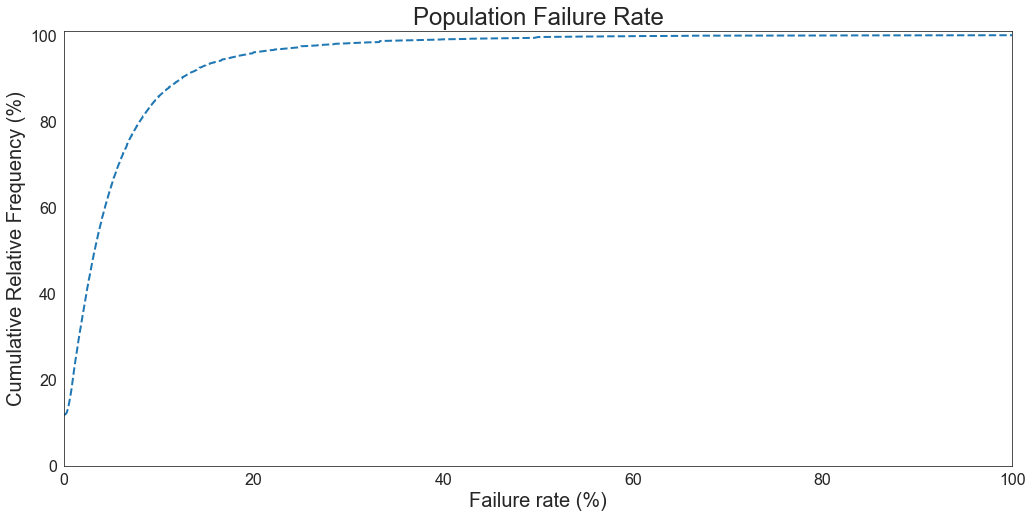

In [105]:
plt.rcParams["figure.figsize"] = (17,8)
ax = frequencyOfFailures.plot(x='failureRate', y='CF', legend=False, ls = '--', lw = 2,)
plt.ylabel('Cumulative Relative Frequency (%)', fontsize=20)
plt.xlabel('Failure rate (%)', fontsize=20)
plt.xlim(0,100)
plt.title("Population Failure Rate", fontsize=24)


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(0,101)

plt.savefig('failureRates.png')
plt.show()

In [106]:
userQuantifiedLogs['loginTimes'] = userQuantifiedLogs['SUCCESS'] + userQuantifiedLogs['FAILURE']

In [107]:
def quartileRange(num):
    if(num<=.25):
        return "first_quartile"
    elif(num>.25 and num <.75):
        return "inter_quartile"
    elif(num>=.75):
        return "third_quartile"

In [108]:
userQuantifiedLogs['quartile'] = userQuantifiedLogs['userPercentage'].apply(lambda num: quartileRange(num))

In [109]:
userQuantifiedLogs["Description"] = userQuantifiedLogs.index.map(subsetOfUsers.set_index("Alias")["Description"].to_dict())

In [110]:
userQuantifiedLogs.head()

Result,New_ID,FAILURE,SUCCESS,failureRate,userPercentage,loginTimes,quartile,Description
Alias,,,,,,,,
user_025618,1,0.0,90.0,0.0,0.000028,90.0,first_quartile,Active (Student)
user_038105,2,0.0,5.0,0.0,0.000056,5.0,first_quartile,Active (Student)
user_008757,3,0.0,102.0,0.0,0.000084,102.0,first_quartile,Active (Student)
user_032408,4,0.0,45.0,0.0,0.000113,45.0,first_quartile,Active (Student)
user_016466,5,0.0,121.0,0.0,0.000141,121.0,first_quartile,Active (Student)


In [111]:
userQuantifiedLogs[['failureRate']].describe()

Result,failureRate
count,35549.000000
mean,0.054799
std,0.076002
min,0.000000
25%,0.012605
50%,0.032432
75%,0.067485
max,1.000000


In [112]:
userQuantifiedLogs.Description.value_counts() / userQuantifiedLogs.shape[0] *100

Active (Student)    91.966019
Active (Faculty)     4.818701
Active (Staff)       3.215280
Name: Description, dtype: float64

In [113]:
userQuantifiedLogs.shape

(35549, 8)

In [114]:
groupStudents = userQuantifiedLogs[userQuantifiedLogs['Description']=='Active (Student)']['failureRate']
groupFaculty = userQuantifiedLogs[userQuantifiedLogs['Description']=='Active (Faculty)']['failureRate']
groupStaff = userQuantifiedLogs[userQuantifiedLogs['Description']=='Active (Staff)']['failureRate']

In [115]:
groupStudents

Alias
user_025618    0.000000
user_038105    0.000000
user_008757    0.000000
user_032408    0.000000
user_016466    0.000000
user_038094    0.000000
user_022289    0.000000
user_049552    0.000000
user_022288    0.000000
user_022285    0.000000
user_038086    0.000000
user_004820    0.000000
user_032416    0.000000
user_004825    0.000000
user_038080    0.000000
user_038054    0.000000
user_032423    0.000000
user_038046    0.000000
user_038035    0.000000
user_022271    0.000000
user_032430    0.000000
user_032434    0.000000
user_016492    0.000000
user_038019    0.000000
user_046836    0.000000
user_022258    0.000000
user_008739    0.000000
user_032438    0.000000
user_004845    0.000000
user_008763    0.000000
user_022310    0.000000
user_038111    0.000000
user_032395    0.000000
user_038247    0.000000
user_038243    0.000000
user_022354    0.000000
user_046797    0.000000
user_022349    0.000000
user_038229    0.000000
user_032366    0.000000
user_022346    0.000000
user_03822

In [71]:
stats.kstest(userQuantifiedLogs['failureRate'], 'norm')

KstestResult(statistic=0.8812062223972545, pvalue=0.0)

In [72]:
stats.shapiro(userQuantifiedLogs['failureRate'])

C:\Users\Francisco\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.6273940801620483, pvalue=0.0)

In [73]:
res = stats.kruskal(groupStudents, groupFaculty, groupStaff)
print(res, res[1]<.05)

KruskalResult(statistic=49.149770790403736, pvalue=2.124530055853818e-11) True


In [74]:
# res = sp.posthoc_mannwhitney([groupStudents, groupFaculty, groupStaff], p_adjust = 'bonferroni').rename(index={1: "students", 2: "faculty", 3: "staff"}, columns={1: "students", 2: "faculty", 3: "staff"})

In [181]:
res = sp.posthoc_dscf([groupStudents, groupFaculty, groupStaff]).rename(index={1: "students", 2: "faculty", 3: "staff"}, columns={1: "students", 2: "faculty", 3: "staff"})

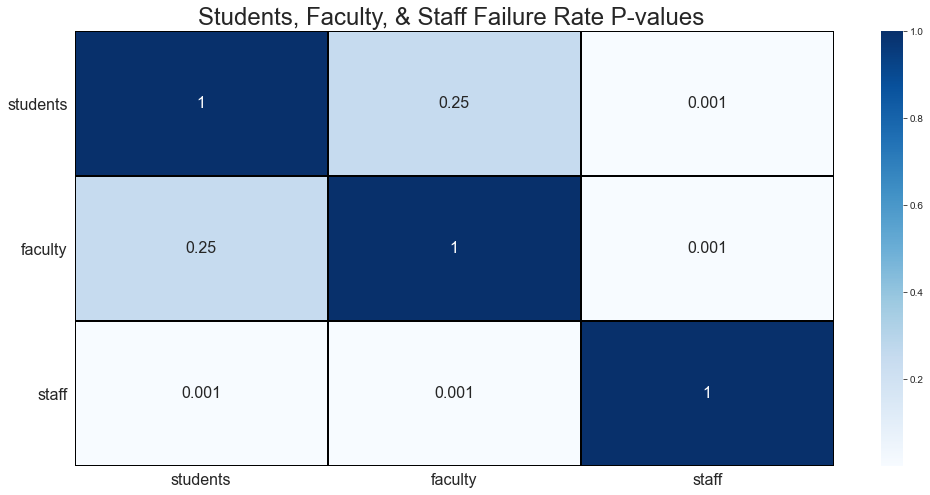

In [182]:
plt.rcParams["figure.figsize"] = (17,8)
sns.heatmap(res,cmap='Blues', linewidths = 1, annot = True, annot_kws={"size": 16}, linecolor='black')
# plt.yticks() 
plt.title('Students, Faculty, & Staff Failure Rate P-values ', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16, rotation=0)
plt.show()

# Blues, coolwarm

In [117]:
d, cliff_res = cliffs_delta(groupStudents,groupStaff)
print(d, cliff_res)

0.12006695871791605 negligible


In [118]:
d, cliff_res = cliffs_delta(groupFaculty,groupStaff)
print(d, cliff_res)

0.08528472761687042 negligible


In [119]:
userQuantifiedLogs['failureRate'] = userQuantifiedLogs['failureRate']*100

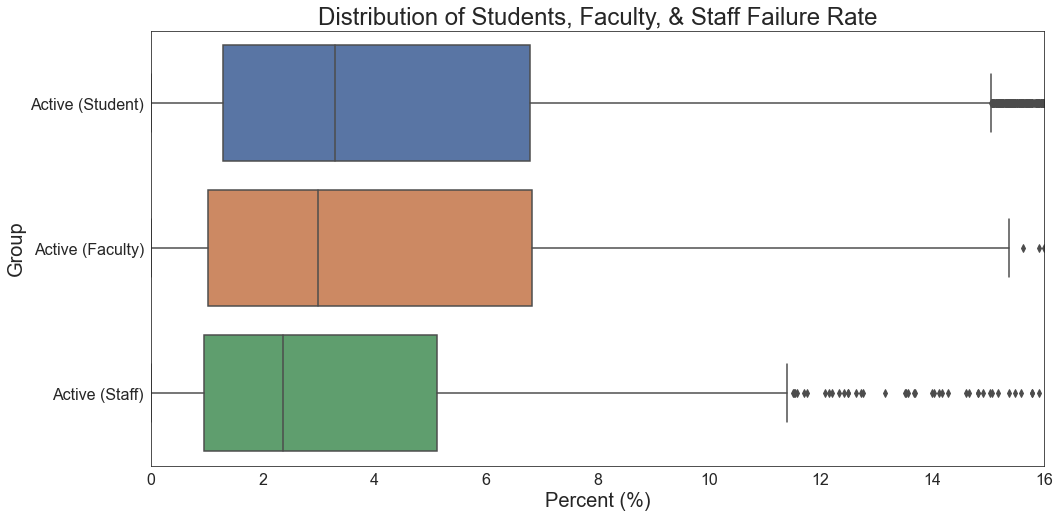

In [183]:
plt.rcParams["figure.figsize"] = (16,8)
sns.set_style("white")
sns.boxplot(y="Description", x="failureRate", data=userQuantifiedLogs, orient="h", palette="deep")
# plt.rcParams["figure.figsize"] = (22,20)
plt.title('Distribution of Students, Faculty, & Staff Failure Rate', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Group', fontsize=20)
plt.xlabel('Percent (%)', fontsize=20)

plt.xlim(0,16)
plt.show()

In [67]:
# sns.catplot(x="Description", y="failureRate", data=userQuantifiedLogs, kind="bar", palette="dark", alpha=.6, height=6)
# # plt.rcParams["figure.figsize"] = (22,20)
# plt.title('Failure Rate Between Groups')
# plt.xlabel('Group')
# plt.ylabel('Percent (%)')
# plt.show()

In [68]:
# plt.rcParams["figure.figsize"] = (8,6)
# sns.boxplot(x="Description", y="failureRate", data=userQuantifiedLogs)
# plt.ylim(0,.2)
# plt.show()

In [69]:
filledNanValues = subsetOfUsers.fillna(0)

In [116]:
def checkForBackup(val):
    if(val==0):
        return False
    else:
        return True

In [117]:
filledNanValues["backup"] = filledNanValues["Phone 2 platform"].apply(lambda val: checkForBackup(val))

In [118]:
userQuantifiedLogs["backup"] = userQuantifiedLogs.index.map(filledNanValues.set_index("Alias")["backup"].to_dict())

In [119]:
userQuantifiedLogs["Phone 1 platform"] = userQuantifiedLogs.index.map(filledNanValues.set_index("Alias")["Phone 1 platform"].to_dict())

In [120]:
userQuantifiedLogs.head()

Result,New_ID,FAILURE,SUCCESS,failureRate,userPercentage,loginTimes,quartile,Description,backup,Phone 1 platform
Alias,,,,,,,,,,
user_025618,1,0.0,90.0,0.0,0.000028,90.0,first_quartile,Active (Student),False,iOS
user_038105,2,0.0,5.0,0.0,0.000056,5.0,first_quartile,Active (Student),False,iOS
user_008757,3,0.0,102.0,0.0,0.000084,102.0,first_quartile,Active (Student),False,iOS
user_032408,4,0.0,45.0,0.0,0.000113,45.0,first_quartile,Active (Student),False,Android
user_016466,5,0.0,121.0,0.0,0.000141,121.0,first_quartile,Active (Student),False,iOS


In [121]:
stats.ttest_ind(userQuantifiedLogs[userQuantifiedLogs['backup']==False]['failureRate'], 
                userQuantifiedLogs[userQuantifiedLogs['backup']==True]['failureRate'])

Ttest_indResult(statistic=-14.154180132425932, pvalue=2.3378085668626262e-45)

In [122]:
from scipy.stats import mannwhitneyu
res = mannwhitneyu(userQuantifiedLogs[userQuantifiedLogs['backup']==False]['failureRate'], 
                userQuantifiedLogs[userQuantifiedLogs['backup']==True]['failureRate'])
res

MannwhitneyuResult(statistic=35715551.0, pvalue=7.136684780974239e-70)

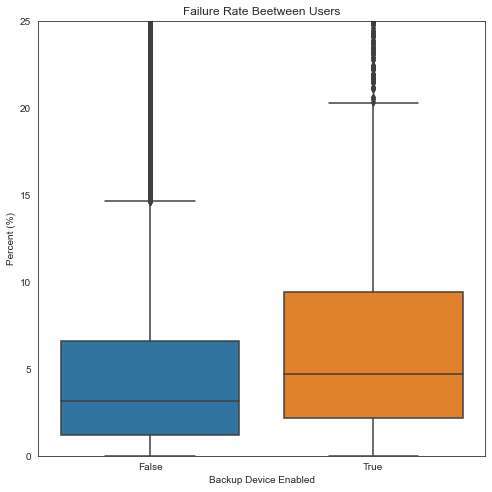

In [125]:
plt.rcParams["figure.figsize"] = (8,8)
sns.boxplot(x="backup", y="failureRate", data=userQuantifiedLogs)
# plt.rcParams["figure.figsize"] = (22,20)
plt.title('Failure Rate Beetween Users')
plt.ylabel('Percent (%)')
plt.xlabel('Backup Device Enabled')
plt.ylim(0,25)
plt.show()

In [126]:
d, cliff_res = cliffs_delta(userQuantifiedLogs[userQuantifiedLogs['backup']==False]['failureRate'], 
                            userQuantifiedLogs[userQuantifiedLogs['backup']==True]['failureRate'])
print(d, cliff_res)

-0.20300877564957243 small


# Android vs Iphone

In [127]:
usersWithoutBackup = userQuantifiedLogs[userQuantifiedLogs["backup"]==False]
mask1 = usersWithoutBackup["Phone 1 platform"]!="Windows Phone"
mask2 = usersWithoutBackup["Phone 1 platform"]!="Unknown"
mask3 = usersWithoutBackup["Phone 1 platform"]!="Landline"
mask4 = usersWithoutBackup["Phone 1 platform"]!="Generic Smartphone"
mask5 = usersWithoutBackup["Phone 1 platform"]!="Mobile"
usersWithoutBackup = usersWithoutBackup[mask1 & mask2 & mask3 & mask4 & mask5]

In [128]:
usersWithoutBackup["Phone 1 platform"].value_counts()

iOS        26098
Android     6049
Name: Phone 1 platform, dtype: int64

In [129]:
usersWithoutBackup.head(1)

Result,New_ID,FAILURE,SUCCESS,failureRate,userPercentage,loginTimes,quartile,Description,backup,Phone 1 platform
Alias,,,,,,,,,,
user_025618,1,0.0,90.0,0.0,0.000028,90.0,first_quartile,Active (Student),False,iOS


In [130]:
from scipy.stats import mannwhitneyu
res = mannwhitneyu(usersWithoutBackup[usersWithoutBackup["Phone 1 platform"]=="iOS"]['failureRate'],
                   usersWithoutBackup[usersWithoutBackup["Phone 1 platform"]=="Android"]['failureRate'])
print(res, res[1]<.05)

MannwhitneyuResult(statistic=75360502.5, pvalue=3.812374753794737e-08) True


In [180]:
# plt.rcParams["figure.figsize"] = (8,8)
# sns.boxplot(x="Phone 1 platform", y="failureRate", data=usersWithoutBackup)
# # plt.rcParams["figure.figsize"] = (22,20)
# plt.title('Failure Rate Beetween OS')
# plt.ylabel('Percent (%)')
# plt.xlabel('Device')
# plt.ylim(0,25)
# plt.show()


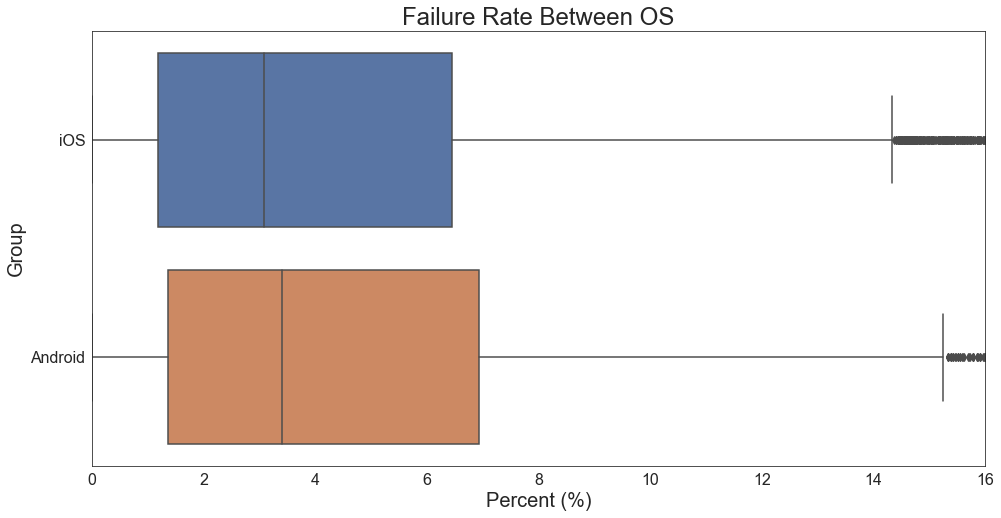

In [134]:
plt.rcParams["figure.figsize"] = (16,8)
sns.set_style("white")
sns.boxplot(y="Phone 1 platform", x="failureRate", data=usersWithoutBackup, orient="h", palette="deep")
plt.title('Failure Rate Between OS', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Group', fontsize=20)
plt.xlabel('Percent (%)', fontsize=20)

plt.xlim(0,16)
plt.show()

In [65]:
d, cliff_res = cliffs_delta(usersWithoutBackup[usersWithoutBackup["Phone 1 platform"]=="iOS"]['failureRate'],
                            usersWithoutBackup[usersWithoutBackup["Phone 1 platform"]=="Android"]['failureRate'])
print(d, cliff_res)

-0.045264722598231895 negligible


In [172]:
# res = stats.kruskal(usersWithoutBackup[usersWithoutBackup["Phone 1 platform"]=="iOS"]['failureRate'],
#                    usersWithoutBackup[usersWithoutBackup["Phone 1 platform"]=="Android"]['failureRate'],
#                    usersWithoutBackup[usersWithoutBackup["Phone 1 platform"]=="Mobile"]['failureRate'],
#                    usersWithoutBackup[usersWithoutBackup["Phone 1 platform"]=="Landline"]['failureRate'],
#                    usersWithoutBackup[usersWithoutBackup["Phone 1 platform"]=="Generic Smartphone"]['failureRate'])
# print(res, res[1]<.05)

In [173]:
# data = [usersWithoutBackup[usersWithoutBackup["Phone 1 platform"]=="iOS"]['failureRate'],
#                    usersWithoutBackup[usersWithoutBackup["Phone 1 platform"]=="Android"]['failureRate'],
#                    usersWithoutBackup[usersWithoutBackup["Phone 1 platform"]=="Mobile"]['failureRate'],
#                    usersWithoutBackup[usersWithoutBackup["Phone 1 platform"]=="Landline"]['failureRate'],
#                    usersWithoutBackup[usersWithoutBackup["Phone 1 platform"]=="Generic Smartphone"]['failureRate']]
# res = sp.posthoc_dscf(data).rename(index={1: "iOS", 2: "Android", 3: "Mobile", 4: "Landline", 5: "Generic Smartphone"}, columns={1: "iOS", 2: "Android", 3: "Mobile", 4: "Landline", 5: "Generic Smartphone"})

In [174]:
# plt.rcParams["figure.figsize"] = (12,6)
# sns.heatmap(res,cmap='coolwarm', linewidths = 0.30, annot = True)
# plt.yticks(rotation=0) 
# plt.xticks(rotation=0)
# plt.title('Pairwise Comparision Between Groups')
# plt.show()

In [175]:
# sns.boxplot(x="Phone 1 platform", y="failureRate", data=usersWithoutBackup)
# # plt.rcParams["figure.figsize"] = (22,20)
# plt.title('Failure Rate Between Devices')
# plt.ylabel('Percent (%)')
# plt.xlabel('Device')
# plt.ylim(0,.2)
# plt.show()

# compare the amount of login times between the three quartiles

In [180]:
res = stats.kruskal(userQuantifiedLogs[userQuantifiedLogs['quartile']=='first_quartile']['loginTimes'],
                    userQuantifiedLogs[userQuantifiedLogs['quartile']=='inter_quartile']['loginTimes'],
                    userQuantifiedLogs[userQuantifiedLogs['quartile']=='third_quartile']['loginTimes'])
print(res, res[1]<.05)

KruskalResult(statistic=1014.7897654847947, pvalue=4.377259349651728e-221) True


In [182]:
data = [userQuantifiedLogs[userQuantifiedLogs['quartile']=='first_quartile']['loginTimes'],
        userQuantifiedLogs[userQuantifiedLogs['quartile']=='inter_quartile']['loginTimes'],
        userQuantifiedLogs[userQuantifiedLogs['quartile']=='third_quartile']['loginTimes']]
res = sp.posthoc_dscf(data).rename(index={1: "first_quartile", 2: "inter_quartile", 3: "third_quartile"}, columns={1: "first_quartile", 2: "inter_quartile", 3: "third_quartile"})

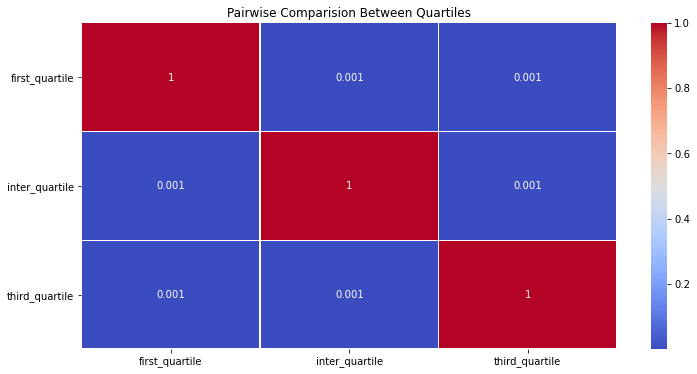

In [183]:
plt.rcParams["figure.figsize"] = (12,6)
sns.heatmap(res,cmap='coolwarm', linewidths = 0.30, annot = True)
plt.yticks(rotation=0) 
plt.xticks(rotation=0)
plt.title('Pairwise Comparision Between Quartiles')
plt.show()

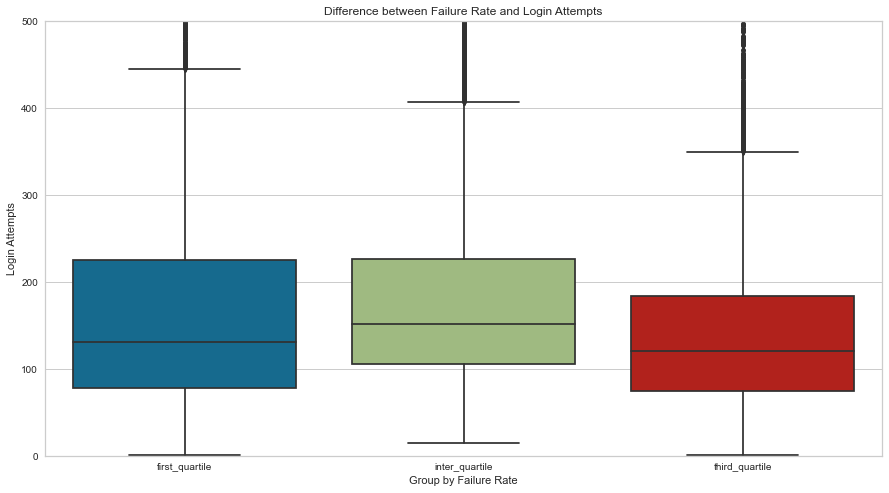

In [537]:
sns.boxplot(x="quartile", y="loginTimes", data=userQuantifiedLogs)
plt.title('Difference between Failure Rate and Login Attempts')
plt.ylabel('Login Attempts')
plt.xlabel('Group by Failure Rate')
plt.ylim(0,500)
plt.show()

In [44]:
userQuantifiedLogs[['failureRate','loginTimes']].corr()

Result,failureRate,loginTimes
Result,,
failureRate,1.000000,-0.123797
loginTimes,-0.123797,1.000000


# Compare error rate by authentication method

In [154]:
modifiedLogs = logs

In [155]:
def modifyFactor(factor):
    if(factor=='Bypass Code' or factor=='Duo Mobile Passcode' or factor=='Hardware Token' or factor=='Yubikey Passcode'):
        return 'Passcode'
    elif(factor=='U2F Token' or factor=='Security Key (WebAuthn)'):
        return 'Security Key'
    else:
        return factor

In [156]:
modifiedLogs['Factor'] = modifiedLogs['Factor'].apply(lambda factor: modifyFactor(factor))

In [157]:
modifiedLogs['Factor'].value_counts()

Duo Push               3768859
Remembered Device      1110270
Phone Call              719045
Passcode                296533
Touch ID (WebAuthn)      17691
Security Key             16023
Bypass Status             2161
Name: Factor, dtype: int64

In [158]:
authLogsByMonth = modifiedLogs.groupby(['month','Factor','Result']).size().unstack(level=2).fillna(0)
authLogsByMonth.head()

Result                   FAILURE  FRAUD   SUCCESS
month Factor                                     
1     Bypass Status          0.0    0.0     383.0
      Duo Push           21304.0   17.0  552141.0
      Passcode            2498.0    0.0   43218.0
      Phone Call          5047.0    0.0  109401.0
      Remembered Device      0.0    0.0  160990.0

In [159]:
authLogsByMonth['failureRate'] = authLogsByMonth['FAILURE'] / (authLogsByMonth['FAILURE'] + authLogsByMonth['SUCCESS'])

In [160]:
authLogsByMonthFailureRate = authLogsByMonth.drop(columns=['FAILURE','FRAUD','SUCCESS'])
authLogsByMonthFailureRate = authLogsByMonthFailureRate.unstack(level=1).fillna(0)
authLogsByMonthFailureRate.columns = authLogsByMonthFailureRate.columns.droplevel()
authLogsByMonthFailureRate.drop(columns=['Bypass Status','Remembered Device'], inplace=True)
authLogsByMonthFailureRate

Factor,Duo Push,Passcode,Phone Call,Security Key,Touch ID (WebAuthn)
month,,,,,
1,0.037151,0.054642,0.044099,0.0,0.0
2,0.025590,0.044757,0.034366,0.0,0.0
3,0.025404,0.043992,0.034587,0.0,0.0
4,0.025418,0.046573,0.034058,0.0,0.0
11,0.030478,0.055427,0.048032,0.0,0.0
12,0.033335,0.050516,0.037511,0.0,0.0


In [161]:
res = stats.kruskal(authLogsByMonthFailureRate['Duo Push'], 
              authLogsByMonthFailureRate['Passcode'],
              authLogsByMonthFailureRate['Phone Call'],
              authLogsByMonthFailureRate['Security Key'],
              authLogsByMonthFailureRate['Touch ID (WebAuthn)'])
print(res, res[1]<.05)

KruskalResult(statistic=27.17874396135266, pvalue=1.8291416285905837e-05) True


In [162]:
data = [authLogsByMonthFailureRate['Duo Push'], 
              authLogsByMonthFailureRate['Passcode'],
              authLogsByMonthFailureRate['Phone Call'],
              authLogsByMonthFailureRate['Security Key'],
              authLogsByMonthFailureRate['Touch ID (WebAuthn)']]
res = sp.posthoc_dscf(data).rename(index={1: "Duo Push", 2: "Passcode", 3: "Phone Call", 4: "Security Key", 5: "Touch ID \n (WebAuthn)"}, columns={1: "Duo Push", 2: "Passcode", 3: "Phone Call", 4: "Security Key", 5: "Touch ID \n (WebAuthn)"})


NaN result encountered.


C:\Users\Francisco\anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:2184: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sqrt(2.) * (u_min - nj * ni / 2.) / np.sqrt(var)


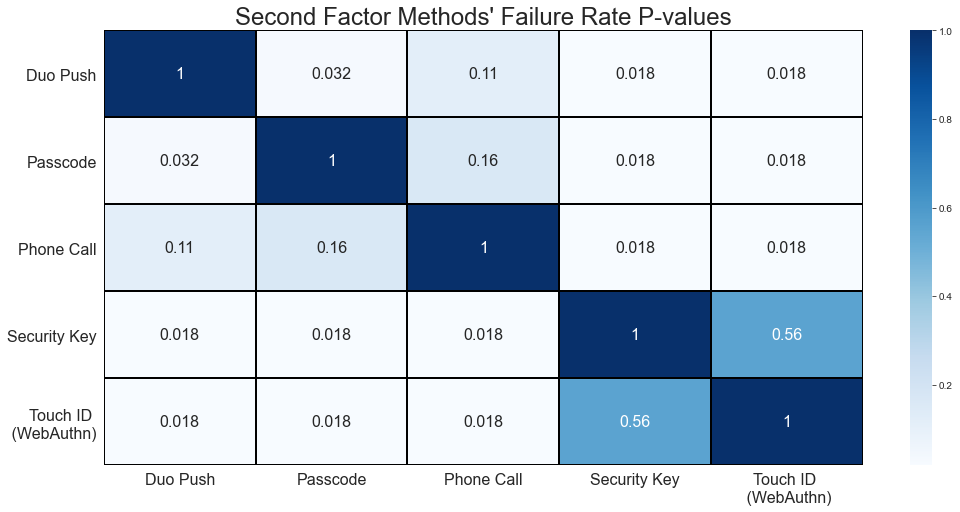

In [163]:
plt.rcParams["figure.figsize"] = (17,8)
sns.heatmap(res,cmap='Blues', linewidths = 1, annot = True, annot_kws={"size": 16}, linecolor='black')
# plt.yticks() 
plt.title("Second Factor Methods' Failure Rate P-values", fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16, rotation=0)

plt.show()

In [164]:
d, cliff_res = cliffs_delta(authLogsByMonthFailureRate['Duo Push'], 
              authLogsByMonthFailureRate['Security Key'])
print(d, cliff_res)

1.0 large


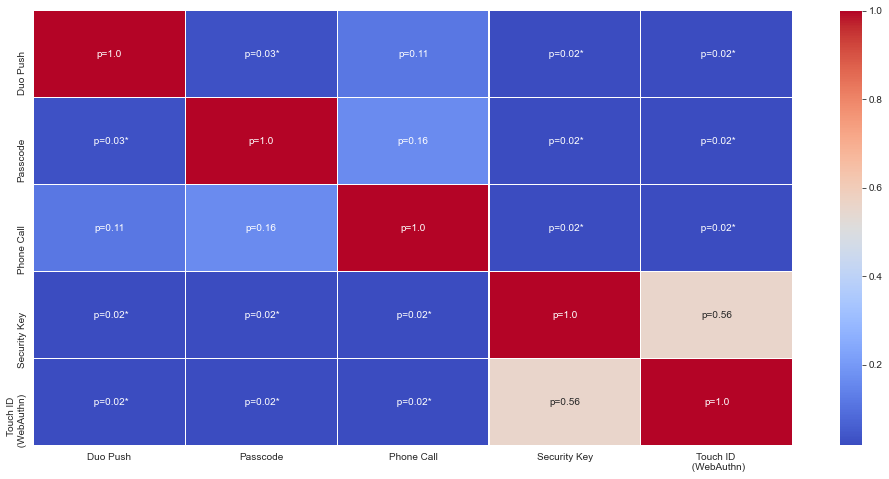

In [165]:
ax = sns.heatmap(res,cmap='coolwarm', linewidths = 0.30, annot = True)
i = 0
j = 0
for t in ax.texts:
#     print(i, j)
#     print(t)
#     break
    if(round(float(t.get_text()),2)<=.01):
        t.set_text(" p=" + str(round(float(t.get_text()),2)) + "**")
    elif(round(float(t.get_text()),2)<.05):
        t.set_text(" p=" + str(round(float(t.get_text()),2)) + "*")
    else:
        t.set_text("p=" + str(round(float(t.get_text()),2)))
    
#     if(i==0 and j==1):
#         t.set_text(t.get_text() + "\n δ= -1.0" )
      
    j += 1
    if(j%5==0):
        i +=1
        j = 0

In [167]:
cliffs_delta(authLogsByMonthFailureRate['Security Key'],authLogsByMonthFailureRate['Duo Push'])

(-1.0, 'large')

In [168]:
cliffs_delta(authLogsByMonthFailureRate['Security Key'],authLogsByMonthFailureRate['Passcode'])

(-1.0, 'large')

In [169]:
cliffs_delta(authLogsByMonthFailureRate['Security Key'],authLogsByMonthFailureRate['Phone Call'])

(-1.0, 'large')

In [170]:
d, cliff_res = cliffs_delta(authLogsByMonthFailureRate['Duo Push'],authLogsByMonthFailureRate['Passcode'])
print(d, cliff_res)

-1.0 large


In [171]:
d, cliff_res = cliffs_delta(authLogsByMonthFailureRate['Duo Push'],authLogsByMonthFailureRate['Security Key'])
print(d, cliff_res)

1.0 large


In [172]:
d, cliff_res = cliffs_delta([1,4,4],[1,2,3])
print(d, cliff_res)

0.4444444444444444 medium


In [173]:
authLogsByMonthFailureRate

Factor,Duo Push,Passcode,Phone Call,Security Key,Touch ID (WebAuthn)
month,,,,,
1,0.037151,0.054642,0.044099,0.0,0.0
2,0.025590,0.044757,0.034366,0.0,0.0
3,0.025404,0.043992,0.034587,0.0,0.0
4,0.025418,0.046573,0.034058,0.0,0.0
11,0.030478,0.055427,0.048032,0.0,0.0
12,0.033335,0.050516,0.037511,0.0,0.0


In [174]:
meltedValues = authLogsByMonthFailureRate.melt()
meltedValues['value'] = meltedValues['value']*100

In [175]:
meltedValues.head()

,Factor,value
0,Duo Push,3.715090
1,Duo Push,2.558983
2,Duo Push,2.540393
3,Duo Push,2.541830
4,Duo Push,3.047830


In [176]:
modifiedLogs.groupby(['Factor','Alias']).size().reset_index().groupby(['Factor']).count()

,Alias,0
Factor,,
Bypass Status,18,18
Duo Push,30919,30919
Passcode,9548,9548
Phone Call,14113,14113
Remembered Device,19846,19846
Security Key,119,119
Touch ID (WebAuthn),322,322


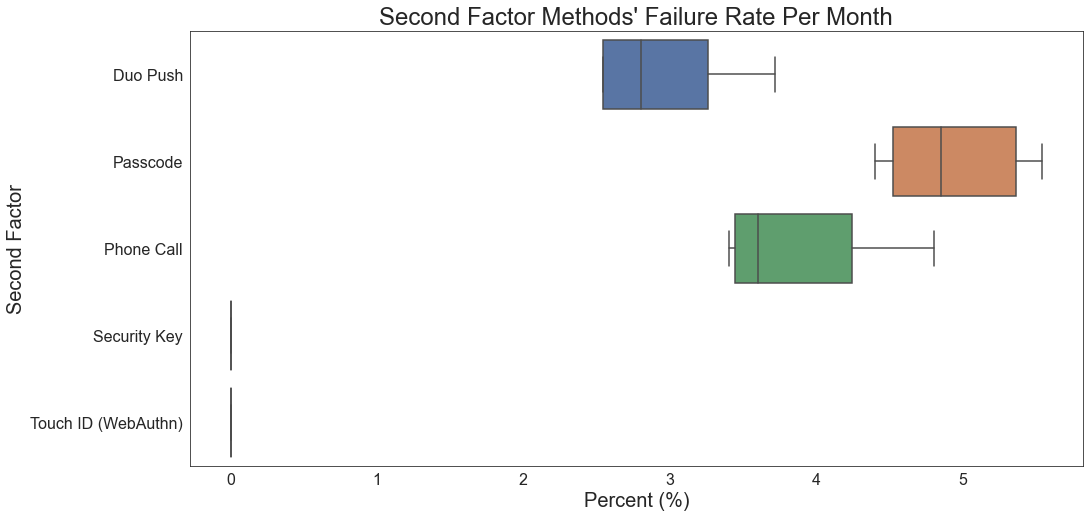

In [177]:
plt.rcParams["figure.figsize"] = (16,8)
sns.set_style("white")
sns.boxplot(y="Factor", x="value", data=meltedValues, orient="h", palette="deep")
plt.title("Second Factor Methods' Failure Rate Per Month", fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Second Factor', fontsize=20)
plt.xlabel('Percent (%)', fontsize=20)

# plt.xlim(0,16)
plt.show()

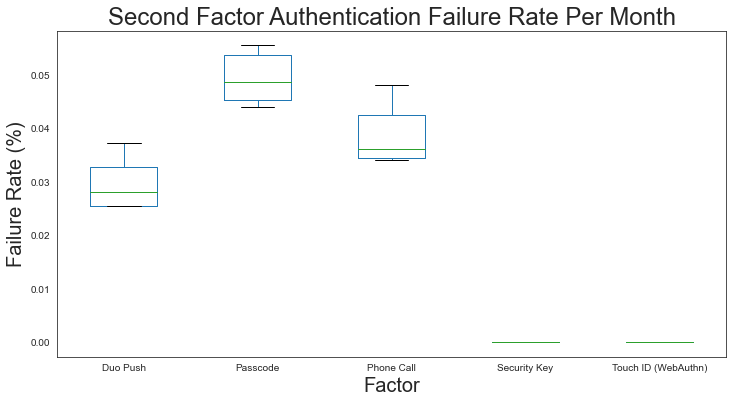

In [185]:
plt.rcParams["figure.figsize"] = (12,6)
authLogsByMonthFailureRate.boxplot(grid=False)
plt.ylabel('Failure Rate (%)', fontsize=20)
plt.xlabel('Factor', fontsize=20)
plt.title('Second Factor Authentication Failure Rate Per Month', fontsize=24)
plt.show()

In [ ]:
# Compare the number of type of errors that occur

In [222]:
users_logs_by_month = logs[logs['Result']=="FAILURE"][["month","Result","Reason"]]

In [223]:
users_logs_by_month.head()

,month,Result,Reason
10,4,FAILURE,No response
14,4,FAILURE,No response
33,4,FAILURE,User cancelled
68,4,FAILURE,No response
84,4,FAILURE,User cancelled


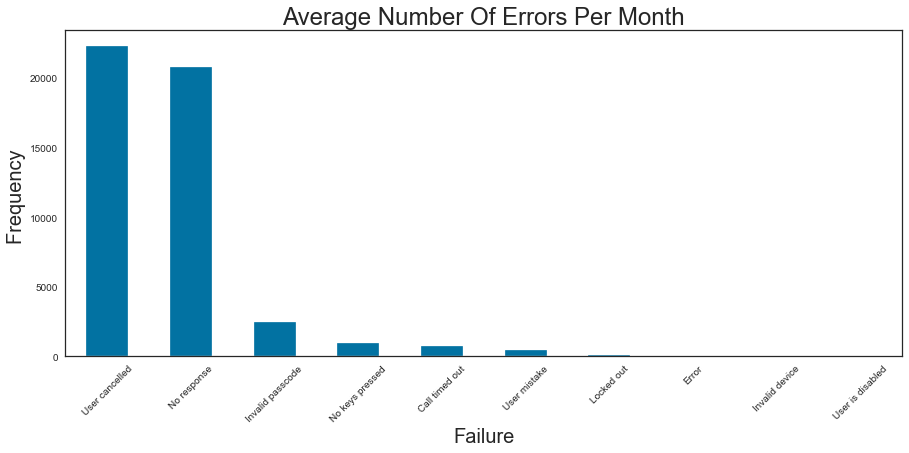

In [224]:
rcParams['figure.figsize'] = 15,6
(users_logs_by_month.Reason.value_counts()/6).plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Frequency ', fontsize=20)
plt.xlabel('Failure', fontsize=20)
plt.title('Average Number Of Errors Per Month', fontsize=24)
plt.show()

In [142]:
userFailures = logs[logs['Result']=="FAILURE"][["Alias","Result","Reason"]]

In [143]:
userFailures = userFailures.groupby(['Alias','Reason']).size()

In [144]:
userFailures = userFailures.unstack(level=1)

In [145]:
userFailures =  userFailures.fillna(0)

In [146]:
def convertValues(val):
    if(val>0):
        return 1
    else:
        return 0

In [147]:
userFailures.iloc[:5,:]

Reason,Call timed out,Error,Invalid device,Invalid passcode,Locked out,No keys pressed,No response,User cancelled,User is disabled,User mistake
Alias,,,,,,,,,,
user_000001,0.0,0.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0
user_000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
user_000003,0.0,0.0,0.0,2.0,0.0,0.0,10.0,19.0,0.0,0.0
user_000004,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0
user_000005,0.0,0.0,0.0,2.0,0.0,0.0,1.0,3.0,0.0,0.0


In [148]:
for i in userFailures.columns:
    userFailures[i] = userFailures[i].apply(convertValues)

In [149]:
userFailures['Count'] = userFailures.sum(axis=1)

In [150]:
userFailures['Proportion'] = userFailures['Count'] / 10

In [151]:
userFailures["Description"] = userFailures.index.map(subsetOfUsers.set_index("Alias")["Description"].to_dict())

In [152]:
userFailures.head()

Reason,Call timed out,Error,Invalid device,Invalid passcode,Locked out,No keys pressed,No response,User cancelled,User is disabled,User mistake,Count,Proportion,Description
Alias,,,,,,,,,,,,,
user_000001,0,0,0,1,0,0,0,1,0,0,2,0.2,Active (Staff)
user_000002,0,0,0,0,0,0,0,1,0,0,1,0.1,Active (Staff)
user_000003,0,0,0,1,0,0,1,1,0,0,3,0.3,Active (Staff)
user_000004,0,0,0,1,0,0,0,1,0,0,2,0.2,Active (Staff)
user_000005,0,0,0,1,0,0,1,1,0,0,3,0.3,Active (Staff)


In [153]:
staffFailures = userFailures[userFailures["Description"]=="Active (Staff)"]
facultyFailures = userFailures[userFailures["Description"]=="Active (Faculty)"]
studentFailures = userFailures[userFailures["Description"]=="Active (Student)"]

In [154]:
# staffFailures.iloc[:,:-1]

In [155]:
(staffFailures.iloc[:,:-1].sum(axis=0)/len(staffFailures.iloc[:,:-1])*100).drop(labels=['Count']).index

Index(['Call timed out', 'Error', 'Invalid device', 'Invalid passcode',
       'Locked out', 'No keys pressed', 'No response', 'User cancelled',
       'User is disabled', 'User mistake', 'Proportion'],
      dtype='object', name='Reason')

In [156]:
facultyTypeOfFailures = facultyFailures.iloc[:,:-1].sum(axis=0)
facultyTypeOfFailures

Reason
Call timed out       111.0
Error                  0.0
Invalid device         1.0
Invalid passcode     282.0
Locked out             7.0
No keys pressed      189.0
No response         1178.0
User cancelled      1102.0
User is disabled       0.0
User mistake          53.0
Count               2923.0
Proportion           292.3
dtype: float64

In [157]:
studentTypeOfFailures = studentFailures.iloc[:,:-1].sum(axis=0)
studentTypeOfFailures

Reason
Call timed out       1607.0
Error                   3.0
Invalid device          5.0
Invalid passcode     4265.0
Locked out            125.0
No keys pressed      2093.0
No response         24447.0
User cancelled      20964.0
User is disabled        2.0
User mistake         2079.0
Count               55590.0
Proportion           5559.0
dtype: float64

In [158]:
staffTypeOfFailures = staffFailures.iloc[:,:-1].sum(axis=0)
staffTypeOfFailures

Reason
Call timed out        66.0
Error                  0.0
Invalid device         2.0
Invalid passcode     273.0
Locked out             7.0
No keys pressed      140.0
No response          762.0
User cancelled       770.0
User is disabled       0.0
User mistake          41.0
Count               2061.0
Proportion           206.1
dtype: float64

In [159]:
dataFrameOfTypeOfFailures = pd.DataFrame(columns = ['Faculty', 'Students','Staff'])
# DataFrame(dict(s1 = facultyTypeOfFailures, s2 = studentTypeOfFailures)).reset_index()

In [160]:
dataFrameOfTypeOfFailures['Faculty'] = facultyTypeOfFailures
dataFrameOfTypeOfFailures['Students'] = studentTypeOfFailures
dataFrameOfTypeOfFailures['Staff'] = staffTypeOfFailures

In [161]:
a = (facultyFailures.iloc[:,:-1].sum(axis=0)/len(facultyFailures.iloc[:,:-1])*100).drop(labels=['Count'])

In [162]:
b = (studentFailures.iloc[:,:-1].sum(axis=0)/len(studentFailures.iloc[:,:-1])*100).drop(labels=['Count'])

In [163]:
c = (staffFailures.iloc[:,:-1].sum(axis=0)/len(staffFailures.iloc[:,:-1])*100).drop(labels=['Count'])

In [164]:
typeOfFailures = pd.concat([a,b,c], axis=1).transpose().rename( index={0: 'Faculty', 1: 'Students', 2: 'Staff'})
typeOfFailures

Reason,Call timed out,Error,Invalid device,Invalid passcode,Locked out,No keys pressed,No response,User cancelled,User is disabled,User mistake,Proportion
Faculty,7.479784,0.000000,0.067385,19.002695,0.471698,12.735849,79.380054,74.258760,0.000000,3.571429,19.696765
Students,5.577537,0.010412,0.017354,14.802860,0.433847,7.264334,84.850062,72.761349,0.006942,7.215743,19.294044
Staff,6.407767,0.000000,0.194175,26.504854,0.679612,13.592233,73.980583,74.757282,0.000000,3.980583,20.009709


In [165]:
typeOfFailures = typeOfFailures.rename(columns={"Invalid device": "Invalid \n device",
                              "Invalid passcode": "Invalid \n passcode",
                              "Locked out": "Locked \n out",
                              "No keys pressed": "No keys \n pressed",
                              "Call timed out": "Call timed \n out",
                              "User mistake": "User \n mistake",
                              "User is disabled": "User is \n disabled",
                              "No response": "No \n response",
                              "User cancelled": "User \n cancelled"})

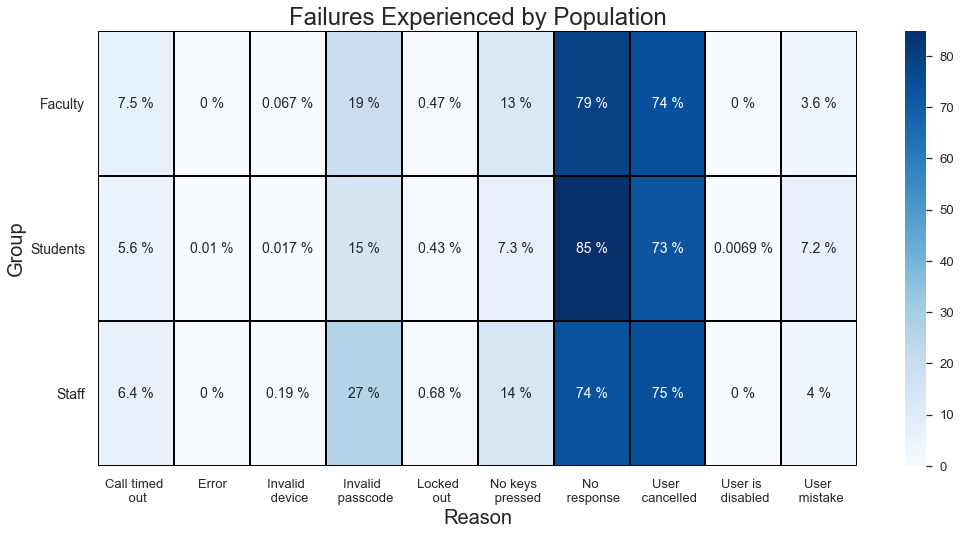

In [200]:
# sns.set(font_scale = 1)
plt.rcParams["figure.figsize"] = (17,8)

g = sns.heatmap(typeOfFailures.drop(columns=['Proportion']),
                 annot=True, cmap='Blues', annot_kws={"size": 14}, linewidth=1, linecolor='black')
for t in g.texts: t.set_text(t.get_text() + " %")
plt.xticks(rotation=0, fontsize=13)
plt.yticks(rotation=0, fontsize=14)
plt.title('Failures Experienced by Population', fontsize=24)

plt.ylabel('Group', fontsize=20)
plt.xlabel('Reason', fontsize=20)

plt.show()

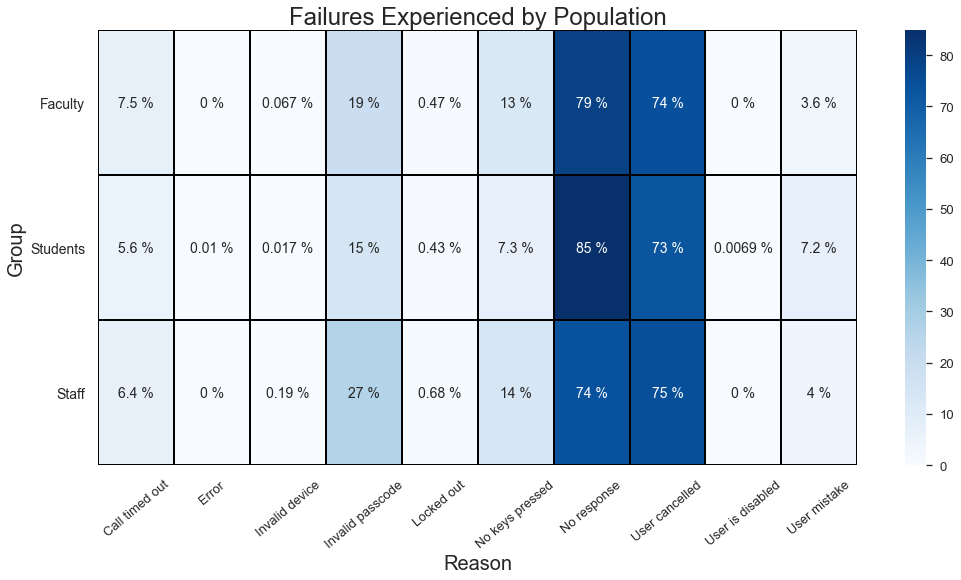

In [182]:
# sns.set(font_scale = 1)
plt.rcParams["figure.figsize"] = (17,8)

g = sns.heatmap(pd.concat([a,b,c], axis=1).transpose().drop(columns=['Proportion']).rename( index={0: 'Faculty', 1: 'Students', 2: 'Staff'}),
                 annot=True, cmap='Blues', annot_kws={"size": 14}, linewidth=1, linecolor='black')
for t in g.texts: t.set_text(t.get_text() + " %")
plt.xticks(rotation=40, fontsize=13)
plt.yticks(rotation=0, fontsize=14)
plt.title('Failures Experienced by Population', fontsize=24)

plt.ylabel('Group', fontsize=20)
plt.xlabel('Reason', fontsize=20)

plt.show()

In [133]:
numberOfUsers

Active (Faculty)     1713
Active (Staff)       1143
Active (Student)    32693
Name: Description, dtype: int64

In [172]:
dataFrameOfTypeOfFailures
for row in dataFrameOfTypeOfFailures.iloc[:-2,:].iterrows():
#     print(int(row[1][2]))
    if(int(row[1][2])!=0):
        p = createFailureDataFrame(row)
        print(p)
        computePairWiseChiSquaredForFailuresByPopulation(p)
    print("===========================================================================================================")
    print("===========================================================================================================")
    print("===========================================================================================================")

66.0
                                Faculty  Students   Staff
Call timed out Experienced        111.0    1607.0    66.0
Call timed out Not Experienced   1602.0   31086.0  1077.0
 
Faculty VS Staff
chi sqaured result = 0.4719988113766826
φ = 0.012855570398000319
p value: 0.492069056222032
False
////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////
Faculty VS Students
chi sqaured result = 8.070957695157826
φ = 0.053159811695838936
p value: 0.004498033718375629
True
////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////
Staff VS Students
chi squared = 1.555345840388264
φ = 0.02333642816901866
p value: 0.21234798200216667
False
2.0
                                Faculty  Students   Staff
Invalid device Experienced          1.0       5.0     2.0
Invalid device Not Experienced   1712.0   32688.0  1141.0
 
Faculty VS Staff
chi

In [136]:
def createFailureDataFrame(row): 
    d = { row[0] + ' Experienced': row[1]}
    failureUsers = pd.DataFrame(data=d)
    print(row[1][2])
    failureUsers[row[0]+' Not Experienced'] = [numberOfUsers[0] - row[1][0],
                                               numberOfUsers[2] - row[1][1],
                                               numberOfUsers[1] - row[1][2]]
    return failureUsers.transpose()

In [137]:
import math

In [171]:
def computePairWiseChiSquaredForFailuresByPopulation(dataFrame):
    pVal = .016
    print(' ')
    print("Faculty VS Staff")
    
    firstChiSquared = chi2_contingency(dataFrame[['Faculty','Staff']])[0]
    n1 = numberOfUsers[0] + numberOfUsers[1]
    s = firstChiSquared / n1
    print('chi sqaured result = ' + str(chi2_contingency(dataFrame[['Faculty','Staff']])[0]))
    print("φ = " + str(math.sqrt(s)))
    print('p value: ' + str(chi2_contingency(dataFrame[['Faculty','Staff']])[1]))
    print(chi2_contingency(dataFrame[['Faculty','Staff']])[1]<pVal)

    
    
    print("////////////////////////////////////////////////////////////////////")
    print("////////////////////////////////////////////////////////////////////")
    
    print("Faculty VS Students")

    secondChiSquared = chi2_contingency(dataFrame[['Faculty','Students']])[0]
    n2 = numberOfUsers[0] + numberOfUsers[2]
    s2 = secondChiSquared / n1  
    print('chi sqaured result = ' + str(chi2_contingency(dataFrame[['Faculty','Students']])[0]))
    print("φ = "+ str(math.sqrt(s2)))
    print('p value: ' + str(chi2_contingency(dataFrame[['Faculty','Students']])[1]))
    print(chi2_contingency(dataFrame[['Faculty','Students']])[1]<pVal)



    print("////////////////////////////////////////////////////////////////////")
    print("////////////////////////////////////////////////////////////////////")
    print("Staff VS Students")

    thirdChiSquared = chi2_contingency(dataFrame[['Staff','Students']])[0]
    n3 = numberOfUsers[1] + numberOfUsers[2]
    s3 = thirdChiSquared / n1  
    print('chi squared = '+ str(thirdChiSquared))
    print("φ = " + str(math.sqrt(s3)))
    print('p value: ' + str(chi2_contingency(dataFrame[['Staff','Students']])[1]))
    print(chi2_contingency(dataFrame[['Staff','Students']])[1]<pVal)
#     print(chi2_contingency(dataFrame[['Active (Staff)','Active (Student)']]))

<AxesSubplot:xlabel='Reason'>

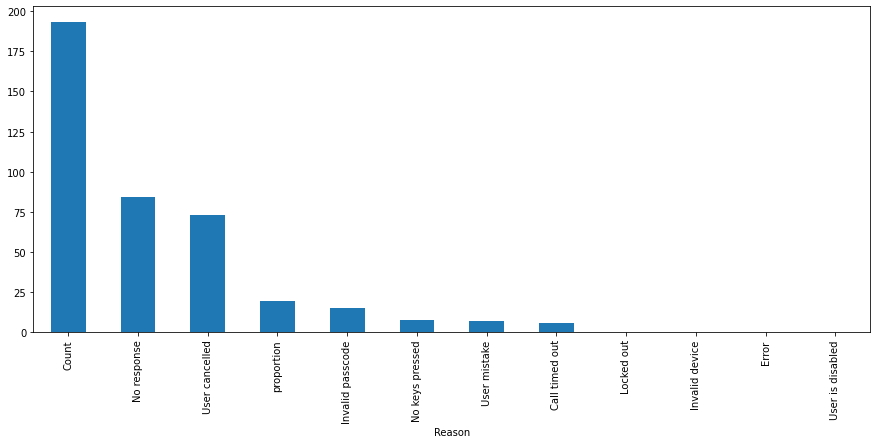

In [289]:
(userFailures.sum(axis=0)/len(userFailures)*100).sort_values(ascending=False).plot.bar()

In [283]:
len(userFailures)

31326

In [ ]:
# percetn of the population that fail each day

In [119]:
logAnlysis = logs
percentOfFailsByDay= logAnlysis.groupby(["Alias", "date", "Result"]).size()


In [120]:
percentOfFailsByDay = percentOfFailsByDay.reset_index()

In [121]:
r = percentOfFailsByDay.groupby(["date","Result"]).size()

In [122]:
r = r.unstack(level=1).drop(columns='FRAUD')["FAILURE"] / r.unstack(level=1).drop(columns='FRAUD')["SUCCESS"]

In [124]:
r.skew()

1.894335634413439

In [101]:
(r * 100).describe()

count    181.000000
mean       6.399339
std        0.942685
min        4.055324
25%        5.819095
50%        6.202597
75%        6.760521
max       12.222617
dtype: float64

In [ ]:
# Determine if the number of users that experince failures per day is stationary

In [193]:
failedLogins = logs[logs["Result"]=="FAILURE"]
failedLoginsByDay = failedLogins.groupby(["Alias","date"]).size()
failedLoginsByDay = failedLoginsByDay.reset_index()
uniqueFailedUsersPerDay = failedLoginsByDay.groupby(["date"]).size()
result = adfuller(uniqueFailedUsersPerDay, autolag='AIC')

In [194]:
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.9995323774078138
p-value: 0.034938093424855834
Critial Values:
   1%, -3.4703698981001665
Critial Values:
   5%, -2.8791138497902193
Critial Values:
   10%, -2.576139407751488


In [195]:
uniqueFailedUsersPerDay.describe()

count     181.000000
mean     1034.629834
std       424.675891
min       239.000000
25%       721.000000
50%      1099.000000
75%      1317.000000
max      3437.000000
dtype: float64

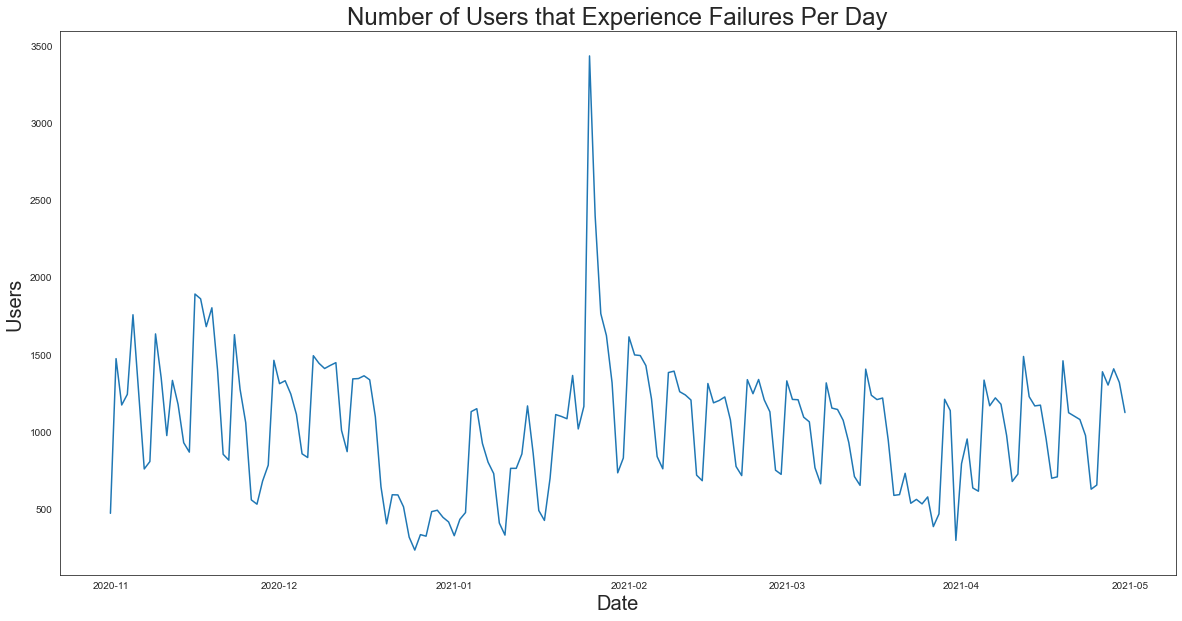

In [211]:
uniqueFailedUsersPerDay.plot(figsize=(20,10))
plt.ylabel('Users ', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.title('Number of Users that Experience Failures Per Day', fontsize=24)
plt.show()

In [428]:
# anomaly detection

In [433]:
# !pip install pycaret

  Using cached pycaret-2.3.6-py3-none-any.whl (301 kB)
  Using cached pandas_profiling-3.1.0-py2.py3-none-any.whl (261 kB)
  Using cached mlflow-1.24.0-py3-none-any.whl (16.5 MB)
  Using cached yellowbrick-1.4-py3-none-any.whl (274 kB)
Processing c:\users\francisco\appdata\local\pip\cache\wheels\f2\64\75\df601da9514261c8cb0830b9515d2b94b5a51f09ddeae92b9e\umap_learn-0.5.2-py3-none-any.whl
  Using cached mlxtend-0.19.0-py2.py3-none-any.whl (1.3 MB)
  Using cached gensim-3.8.3-cp38-cp38-win_amd64.whl (24.2 MB)
  Using cached lightgbm-3.3.2-py3-none-win_amd64.whl (1.0 MB)
  Using cached spacy-2.3.7-cp38-cp38-win_amd64.whl (9.7 MB)
Processing c:\users\francisco\appdata\local\pip\cache\wheels\6b\76\62\6da97734911ffcbdd559fd1a3f28526321f0ae699182a23866\cufflinks-0.17.3-py3-none-any.whl
Processing c:\users\francisco\appdata\local\pip\cache\wheels\1c\3b\f6\0abfb384d3c5b855fdeacdc817a4374f924a90e583ceacb536\pyod-0.9.8-py3-none-any.whl
  Using cached kmodes-0.11.1-py2.py3-none-any.whl (19 kB)
  U

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

spacy-transformers 1.0.2 requires spacy<3.1.0,>=3.0.0, but you'll have spacy 2.3.7 which is incompatible.
spacy-transformers 1.0.2 requires srsly<3.0.0,>=2.4.0, but you'll have srsly 1.0.5 which is incompatible.
en-core-web-trf 3.0.0 requires spacy<3.1.0,>=3.0.0, but you'll have spacy 2.3.7 which is incompatible.
en-core-web-sm 3.0.0 requires spacy<3.1.0,>=3.0.0, but you'll have spacy 2.3.7 which is incompatible.
pandas-profiling 3.1.0 requires joblib~=1.0.1, but you'll have joblib 0.17.0 which is incompatible.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you'll have scikit-learn 0.23.2 which is incompatible.


In [103]:
from pycaret.anomaly import *

In [104]:
dt = uniqueFailedUsersPerDay.to_frame()

In [105]:
s = setup(dt, session_id = 123)

,Description,Value
0,session_id,123
1,Original Data,"(181, 1)"
2,Missing Values,False
3,Numeric Features,1
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(181, 1)"
9,CPU Jobs,-1


In [106]:
# train model
iforest = create_model('iforest', fraction = 0.1)
iforest_results = assign_model(iforest)
iforest_results.head()

,0,Anomaly,Anomaly_Score
date,,,
2020-11-01,477,0,-0.041067
2020-11-02,1478,0,-0.046982
2020-11-03,1178,0,-0.121564
2020-11-04,1247,0,-0.105072
2020-11-05,1762,1,0.044389


In [107]:
anomalyPoints = iforest_results[iforest_results['Anomaly']==1][[0]].squeeze()

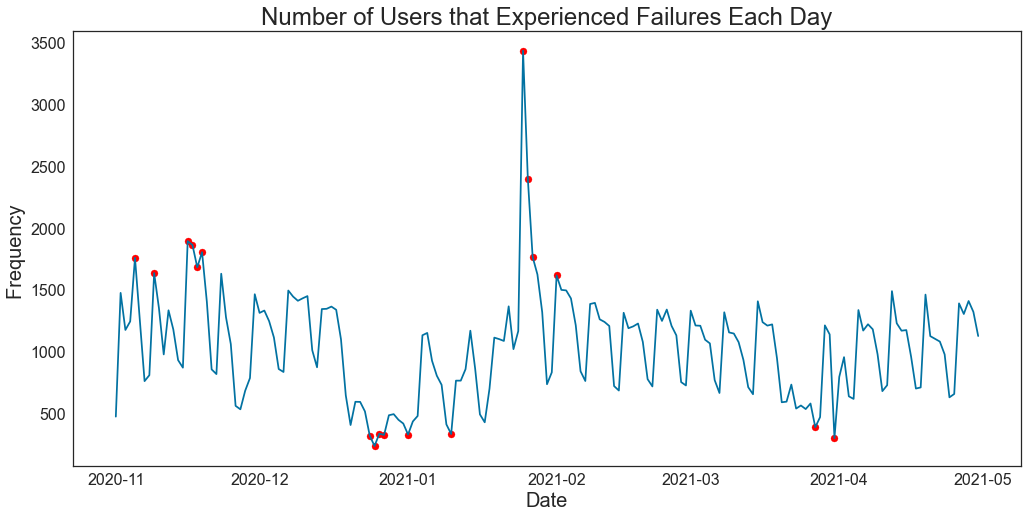

In [110]:
plt.rcParams["figure.figsize"] = (17,8)
sns.set_style("white")
plt.plot(uniqueFailedUsersPerDay)
plt.scatter(anomalyPoints.index,anomalyPoints,color='red')
plt.ylabel('Frequency ', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.title('Number of Users that Experienced Failures Each Day', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [470]:
uniqueFailedUsersPerDay.describe()

count     181.000000
mean     1034.629834
std       424.675891
min       239.000000
25%       721.000000
50%      1099.000000
75%      1317.000000
max      3437.000000
dtype: float64

In [471]:
anomalyPoints

date
2020-11-05    1762
2020-11-09    1638
2020-11-16    1896
2020-11-17    1865
2020-11-18    1685
2020-11-19    1807
2020-12-24     323
2020-12-25     239
2020-12-26     339
2020-12-27     329
2021-01-01     332
2021-01-10     336
2021-01-25    3437
2021-01-26    2401
2021-01-27    1769
2021-02-01    1619
2021-03-27     391
2021-03-31     302
Name: 0, dtype: int64

In [ ]:
# failed logins per day

In [196]:
failedLoginsByDay = failedLogins.groupby(["date"]).size()

In [197]:
failedLoginsByDay.describe()

count     181.000000
mean     1586.861878
std       720.367327
min       360.000000
25%      1047.000000
50%      1646.000000
75%      1981.000000
max      5868.000000
dtype: float64

In [198]:
# Determine if the error Rate by month is stationary 

In [199]:
failedLoginsByMonth = failedLogins.groupby(["month"]).size()
failedLoginsByMonthRearranged = failedLoginsByMonth.reindex([11,12,1,2,3,4])
failedLoginsByMonthRearranged = failedLoginsByMonthRearranged.rename( index={11: 'November', 12: 'December', 1: 'January', 2: 'Febuary', 3: 'March', 4: 'April'})

In [260]:
resultOfFailedLoginsPerMonth = adfuller(failedLoginsByMonthRearranged, autolag='AIC')
print(f'ADF Statistic: {resultOfFailedLoginsPerMonth[0]}')
print(f'p-value: {resultOfFailedLoginsPerMonth[1]}')
for key, value in resultOfFailedLoginsPerMonth[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.392379980292384
p-value: 0.0003061866045139951
Critial Values:
   1%, -6.045114
Critial Values:
   5%, -3.9292800000000003
Critial Values:
   10%, -2.98681


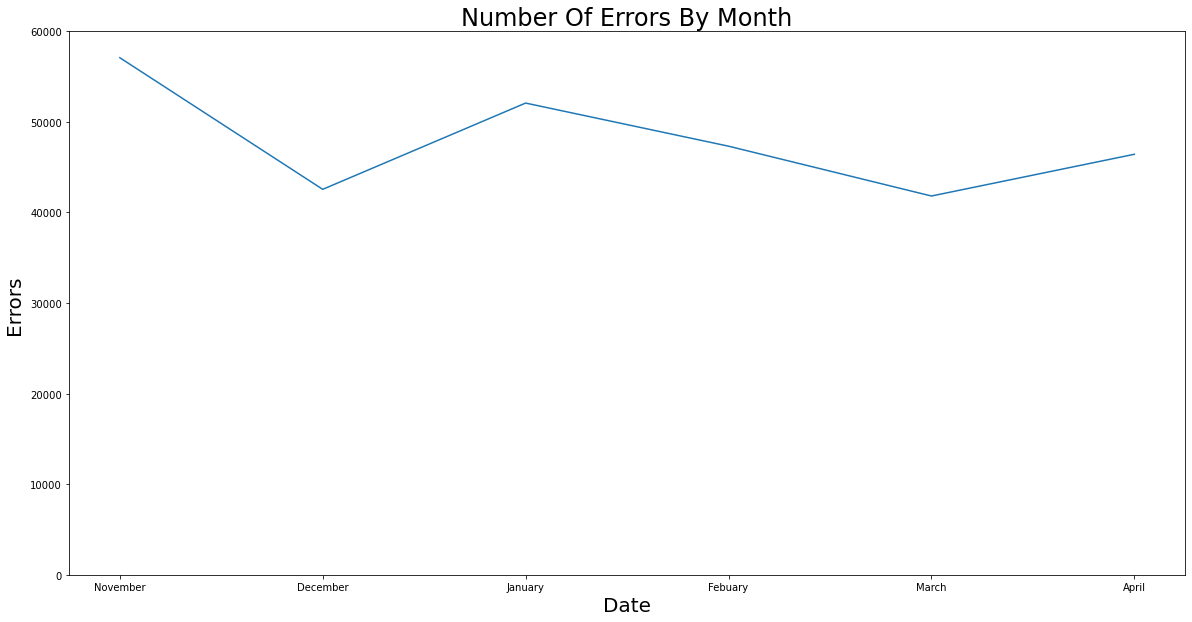

In [225]:
failedLoginsByMonthRearranged.plot(figsize=(20,10))
plt.ylim(0,60000)

plt.ylabel('Errors ', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.title('Number Of Errors By Month', fontsize=24)
plt.show()

In [217]:
failedLoginsByMonth = failedLogins.groupby(['month','date']).size()

In [218]:
failedLoginsByMonth = failedLoginsByMonth.reset_index().rename(columns={0: 'frequency'})[['month','frequency']]

In [219]:
nameOfMonthDict = {11:'November', 12:'December', 1: 'January', 2: 'February', 3: 'March', 4: 'April'}

In [220]:
failedLoginsByMonth = failedLoginsByMonth.replace(nameOfMonthDict)

In [221]:
failedLoginsByMonth['frequency'].describe()

count     181.000000
mean     1586.861878
std       720.367327
min       360.000000
25%      1047.000000
50%      1646.000000
75%      1981.000000
max      5868.000000
Name: frequency, dtype: float64

In [222]:
d, cliff_res = cliffs_delta(failedLoginsByMonth[failedLoginsByMonth['month']=="November"]['frequency'], failedLoginsByMonth[failedLoginsByMonth['month']=="March"]['frequency'])
print(d, cliff_res)

0.45161290322580644 medium


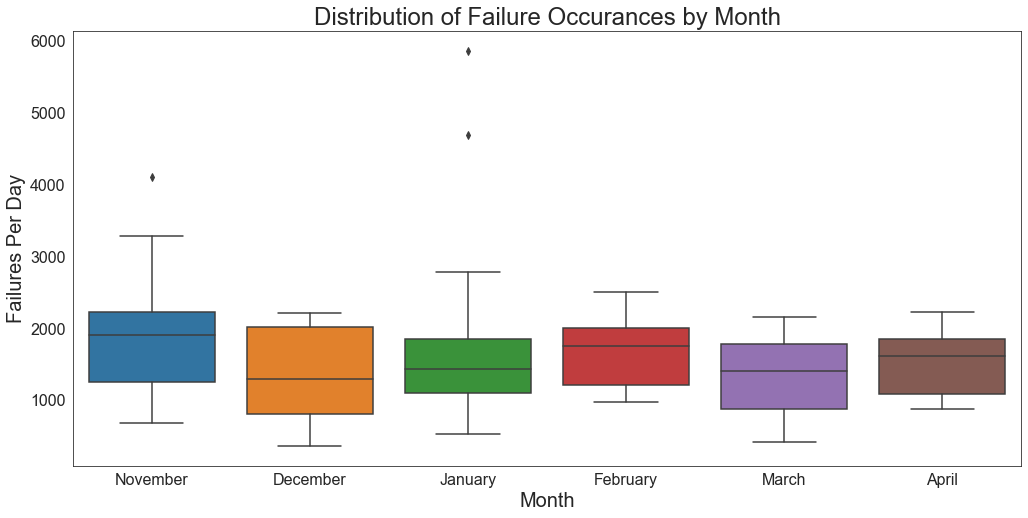

In [224]:
plt.rcParams["figure.figsize"] = (17,8)
sns.set_style("white")
sns.boxplot(x="month", y="frequency", data=failedLoginsByMonth, order=['November','December','January','February','March','April'])
plt.ylabel('Failures Per Day', fontsize=20)
plt.xlabel('Month', fontsize=20)
# plt.ylim(0,4000)
plt.title('Distribution of Failure Occurances by Month', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [527]:
failedLoginsByMonth[failedLoginsByMonth['month']=='November']['frequency'].head()

120     687
121    2196
122    1818
123    1895
124    4107
Name: frequency, dtype: int64

In [83]:
res = stats.kruskal(failedLoginsByMonth[failedLoginsByMonth['month']=='November']['frequency'],
                    failedLoginsByMonth[failedLoginsByMonth['month']=='December']['frequency'],
                    failedLoginsByMonth[failedLoginsByMonth['month']=='January']['frequency'],
                    failedLoginsByMonth[failedLoginsByMonth['month']=='February']['frequency'],
                    failedLoginsByMonth[failedLoginsByMonth['month']=='March']['frequency'],
                    failedLoginsByMonth[failedLoginsByMonth['month']=='April']['frequency'])
print(res, res[1]<.05)

KruskalResult(statistic=13.672473745616825, pvalue=0.01782936843857173) True


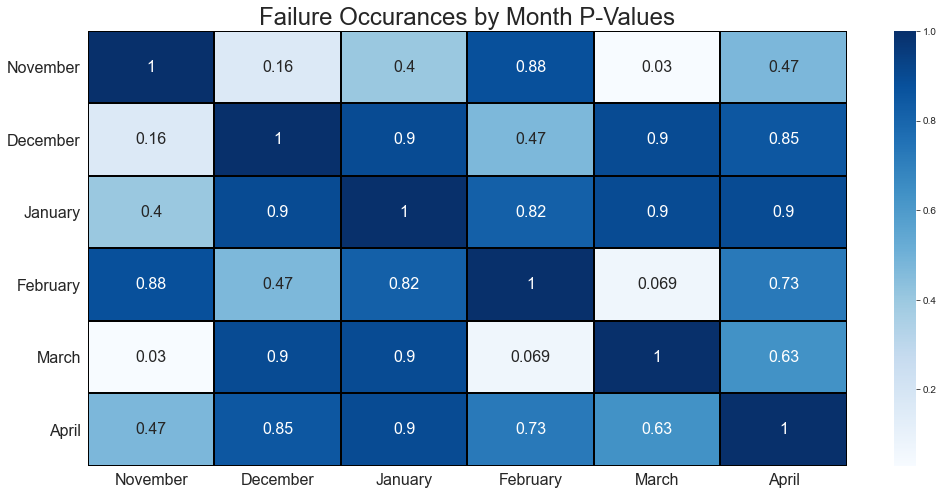

In [85]:
plt.rcParams["figure.figsize"] = (17,8)
res = sp.posthoc_dscf([failedLoginsByMonth[failedLoginsByMonth['month']=='November']['frequency'],
                    failedLoginsByMonth[failedLoginsByMonth['month']=='December']['frequency'],
                    failedLoginsByMonth[failedLoginsByMonth['month']=='January']['frequency'],
                    failedLoginsByMonth[failedLoginsByMonth['month']=='February']['frequency'],
                    failedLoginsByMonth[failedLoginsByMonth['month']=='March']['frequency'],
                    failedLoginsByMonth[failedLoginsByMonth['month']=='April']['frequency']]).rename(index={1:'November', 2:'December', 3: 'January', 4: 'February', 5: 'March', 6: 'April'}, columns={1:'November', 2:'December', 3: 'January', 4: 'February', 5: 'March', 6: 'April'})
sns.heatmap(res,cmap='Blues', linewidths = 0.30, annot = True,  annot_kws={"size": 16}, linewidth=1, linecolor="black")
plt.yticks(rotation=0) 
plt.title('Failure Occurances by Month P-Values', fontsize=24)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)



plt.show()

In [220]:
d, cliff_res = cliffs_delta(failedLoginsByMonth[failedLoginsByMonth['month']=='November']['frequency'],
                            failedLoginsByMonth[failedLoginsByMonth['month']=='March']['frequency'])
print(d, cliff_res)

0.45161290322580644 medium


In [ ]:
# Compute the number of errors that occur throughout the week

In [200]:
logs["Day"] = logs["date"].apply(lambda date: date.strftime('%a'))

In [201]:
failedLogins["Day"] = failedLogins["date"].apply(lambda date: date.strftime('%a'))

<ipython-input-201-f2bc25ce13c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failedLogins["Day"] = failedLogins["date"].apply(lambda date: date.strftime('%a'))


In [202]:
sumOfFailedLogingsEachDay = failedLogins.groupby(['date','Day']).size().unstack(level=1).sum()

In [203]:
numberOfEachWeekDay = failedLogins.groupby(["date", "Day"]).size().unstack(level=1).count()

In [204]:
failedAverageLoginsByDay = sumOfFailedLogingsEachDay.div(numberOfEachWeekDay)
failedAverageLoginsByDay

Day
Fri    1510.115385
Mon    2104.038462
Sat    1052.840000
Sun    1019.923077
Thu    1788.192308
Tue    1900.115385
Wed    1712.269231
dtype: float64

In [205]:
failsPerDay = failedLogins.groupby(['date','Day']).size().reset_index()[['Day',0]]

In [206]:
failsOnMonday = failsPerDay[failsPerDay['Day']=="Mon"].iloc[:25]
failsOnTuesday = failsPerDay[failsPerDay['Day']=="Tue"].iloc[:25]
failsOnWednesday = failsPerDay[failsPerDay['Day']=="Wed"].iloc[:25]
failsOnThursday = failsPerDay[failsPerDay['Day']=="Thu"].iloc[:25]
failsOnFriday = failsPerDay[failsPerDay['Day']=="Fri"].iloc[:25]
failsOnSaturday = failsPerDay[failsPerDay['Day']=="Sat"].iloc[:25]
failsOnSunday = failsPerDay[failsPerDay['Day']=="Sun"].iloc[:25]

In [207]:
res = stats.kruskal(failsOnMonday[0], 
                    failsOnTuesday[0], 
                    failsOnWednesday[0], 
                    failsOnThursday[0], 
                    failsOnFriday[0], 
                    failsOnSaturday[0],
                    failsOnSunday[0])
print(res, res[1]<.05)

KruskalResult(statistic=62.38068195558424, pvalue=1.4758665707972378e-11) True


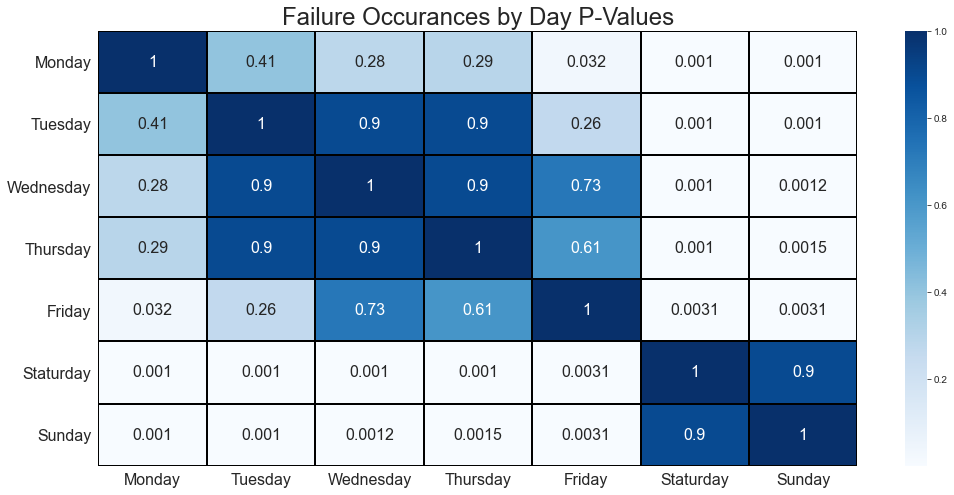

In [208]:
plt.rcParams["figure.figsize"] = (17,8)
res = sp.posthoc_dscf([failsOnMonday[0], 
                    failsOnTuesday[0], 
                    failsOnWednesday[0], 
                    failsOnThursday[0], 
                    failsOnFriday[0], 
                    failsOnSaturday[0],
                    failsOnSunday[0]]).rename(index={1: "Monday", 2: "Tuesday", 3: "Wednesday", 4:"Thursday", 5:"Friday", 6:"Staturday", 7:"Sunday"}, columns={1: "Monday", 2: "Tuesday", 3: "Wednesday", 4:"Thursday", 5:"Friday", 6:"Staturday", 7:"Sunday"})
sns.heatmap(res,cmap='Blues', linewidths = 0.30, annot = True, annot_kws={"size": 16}, linewidth=1, linecolor="black")
plt.yticks(rotation=0) 
plt.title('Failure Occurances by Day P-Values', fontsize=24)


plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation=0)
plt.show()

In [209]:
d, cliff_res = cliffs_delta(failsOnMonday[0],
                            failsOnSaturday[0])
print(d, cliff_res)

0.8048 large


In [210]:
d, cliff_res = cliffs_delta(failsOnTuesday[0],
                            failsOnSaturday[0])
print(d, cliff_res)

0.792 large


In [ ]:
d, cliff_res = cliffs_delta(failsOnWednesday[0],
                            failsOnSaturday[0])
print(d, cliff_res)

In [ ]:
d, cliff_res = cliffs_delta(failsOnThursday[0],
                            failsOnSaturday[0])
print(d, cliff_res)

In [ ]:
d, cliff_res = cliffs_delta(failsOnFriday[0],
                            failsOnSaturday[0])
print(d, cliff_res)

In [ ]:
d, cliff_res = cliffs_delta(failsOnMonday[0],
                            failsOnSunday[0])
print(d, cliff_res)

In [ ]:
d, cliff_res = cliffs_delta(failsOnTuesday[0],
                            failsOnSunday[0])
print(d, cliff_res)

In [ ]:
d, cliff_res = cliffs_delta(failsOnWednesday[0],
                            failsOnSunday[0])
print(d, cliff_res)

In [ ]:
d, cliff_res = cliffs_delta(failsOnThursday[0],
                            failsOnSunday[0])
print(d, cliff_res)

In [ ]:
d, cliff_res = cliffs_delta(failsOnFriday[0],
                            failsOnSunday[0])
print(d, cliff_res)

In [ ]:
# "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"

In [211]:
failsPerDay = failsPerDay.rename(columns={0: "times"})

In [212]:
days = {"Mon": "Monday", "Tue": "Tuesday", "Wed": "Wednesday", "Thu":"Thursday", "Fri":"Friday", "Sat":"Saturday", "Sun":"Sunday"}

In [213]:
failsPerDay['Day'] = failsPerDay['Day'].replace(days)

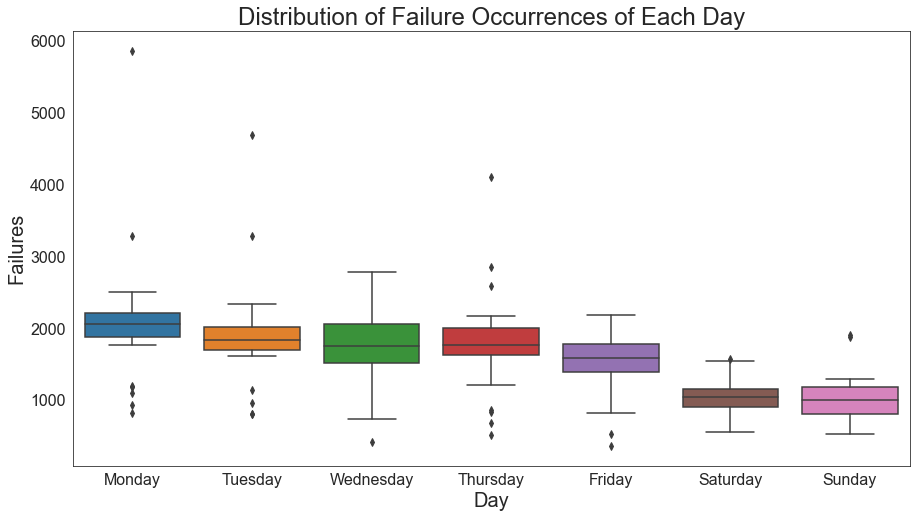

In [215]:
plt.rcParams["figure.figsize"] = (15,8)
sns.set_style("white")
sns.boxplot(x="Day", y="times", data=failsPerDay, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.ylabel('Failures', fontsize=20)
plt.xlabel('Day', fontsize=20)
# plt.ylim(0,4000)
plt.title('Distribution of Failure Occurrences of Each Day', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (15,8)
sns.boxplot(x="Day", y="times", data=failsPerDay, order=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.ylabel('Failures ', fontsize=20)
plt.xlabel('Day', fontsize=20)
plt.ylim(0,4000)
plt.title('Failure Occurances of Each Day')
plt.show()

In [204]:
failedLoginsByDay = failedAverageLoginsByDay.reindex(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])

In [205]:
resultOfFailedLoginsByDay = adfuller(failedLoginsByDay, autolag='AIC')

In [206]:
print(f'ADF Statistic: {resultOfFailedLoginsByDay[0]}')
print(f'p-value: {resultOfFailedLoginsByDay[1]}')
for key, value in resultOfFailedLoginsByDay[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.3547542363157645
p-value: 0.917383536410194
Critial Values:
   1%, -5.354256481481482
Critial Values:
   5%, -3.6462381481481483
Critial Values:
   10%, -2.901197777777778


In [207]:
tau, p_value = stats.kendalltau([1,2,3,4,5,6,7], failedLoginsByDay)
print(tau, p_value)

-0.9047619047619049 0.002777777777777778


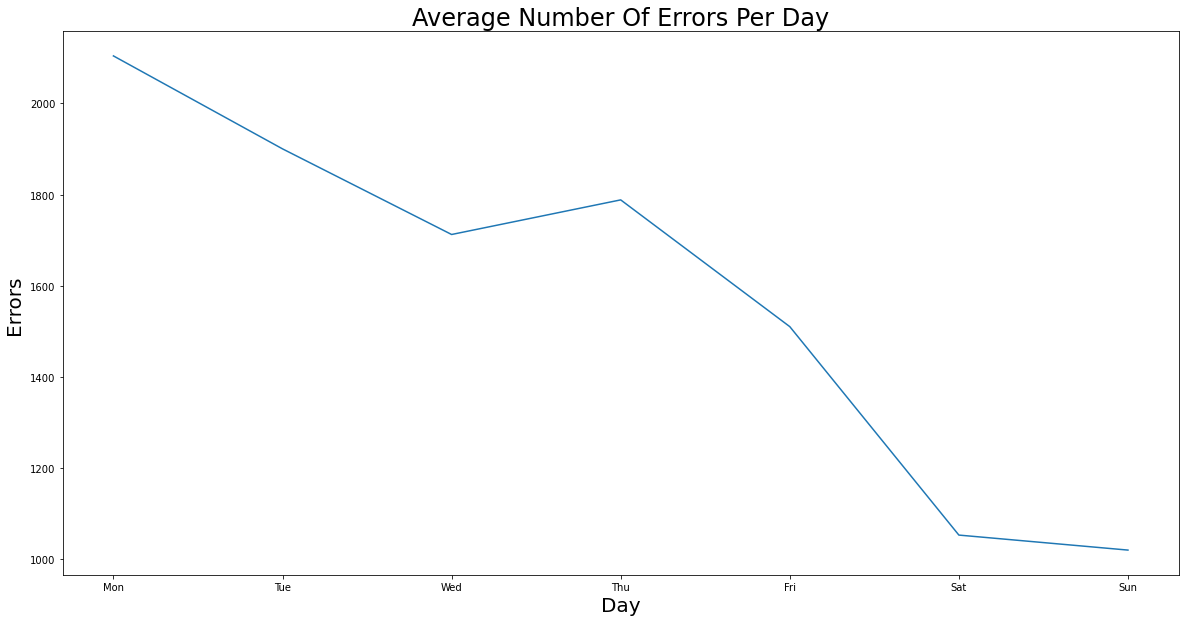

In [208]:
failedLoginsByDay.plot(figsize=(20,10))
plt.ylabel('Errors ', fontsize=20)
plt.xlabel('Day', fontsize=20)
plt.title('Average Number Of Errors Per Day', fontsize=24)
plt.show()

In [209]:
# compare the number of errors that occur at each hour of the day

In [210]:
failedLogins.head()

,Timestamp (UTC),Alias,Integration,Factor,Result,Reason,Enrollment,Access Device Country,Access Device State,Access Device City,Access Device Hostname,date,month,hour,minute,second,Day
10,2021-04-01 07:00:38.171370+00:00,user_048070,Single Sign-On,Duo Push,FAILURE,No response,False,US,California,West Sacramento,NaN,2021-04-01,4,7,0,38,Thu
14,2021-04-01 07:00:47.088446+00:00,user_018970,Single Sign-On,Duo Push,FAILURE,No response,False,US,California,Oxnard,NaN,2021-04-01,4,7,0,47,Thu
33,2021-04-01 07:01:52.897370+00:00,user_021380,Single Sign-On,NaN,FAILURE,User cancelled,False,US,California,Oakland,NaN,2021-04-01,4,7,1,52,Thu
68,2021-04-01 07:04:24.186870+00:00,user_051724,Single Sign-On,Duo Push,FAILURE,No response,False,JP,Aomori,Misawa,NaN,2021-04-01,4,7,4,24,Thu
84,2021-04-01 07:05:29.947741+00:00,user_017591,Single Sign-On,NaN,FAILURE,User cancelled,False,US,California,Sacramento,NaN,2021-04-01,4,7,5,29,Thu


In [226]:
failedLoginsByDayAndHour = failedLogins.groupby(['Day','hour']).size().unstack().reindex(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])

In [227]:
failedLoginsByDayAndHour = failedLoginsByDayAndHour.transpose()

In [228]:
failedLoginsByDayAndHour

Day,Mon,Tue,Wed,Thu,Fri,Sat,Sun
hour,,,,,,,
0,2052,2866,2685,2378,2570,1955,1275
1,2448,2704,2531,2482,2337,1928,1491
2,2785,2354,2279,2047,2188,1795,1348
3,2817,2242,2148,2176,2023,1702,1348
4,3001,2241,2123,2052,1997,1982,1311
5,2757,2080,1944,2290,1833,1715,1515
6,2302,1662,1552,1943,1547,1630,1247
7,1567,1220,1111,1331,1091,1157,891
8,978,636,669,913,610,498,506


In [229]:
numbOfDays = failedLogins.groupby(['date','Day']).size().reset_index()

In [230]:
numbOfDays.Day.value_counts()

Sun    26
Mon    26
Tue    26
Wed    26
Thu    26
Fri    26
Sat    25
Name: Day, dtype: int64

In [231]:
hoursOutsideIRTWeekdays = failedLoginsByDayAndHour.iloc[0:8,:-2].append(failedLoginsByDayAndHour.iloc[-7:,:-2])

In [232]:
hoursOutsideIRTWeekdays.sum(axis=0).div(failedLoginsByDayAndHour.iloc[:,:-2].sum(axis=0))

Day
Mon    0.832758
Tue    0.846123
Wed    0.842090
Thu    0.822618
Fri    0.848254
dtype: float64

In [233]:
(hoursOutsideIRTWeekdays.sum(axis=0).div(failedLoginsByDayAndHour.iloc[:,:-2].sum(axis=0))*100).mean()

83.83685314078323

In [234]:
hoursOutsideIRTWeekends = failedLoginsByDayAndHour.iloc[0:10,-2:].append(failedLoginsByDayAndHour.iloc[-10:,-2:])

In [235]:
(hoursOutsideIRTWeekends.sum(axis=0).div(failedLoginsByDayAndHour.iloc[:,-2:].sum(axis=0))*100).mean()

97.25336594682406

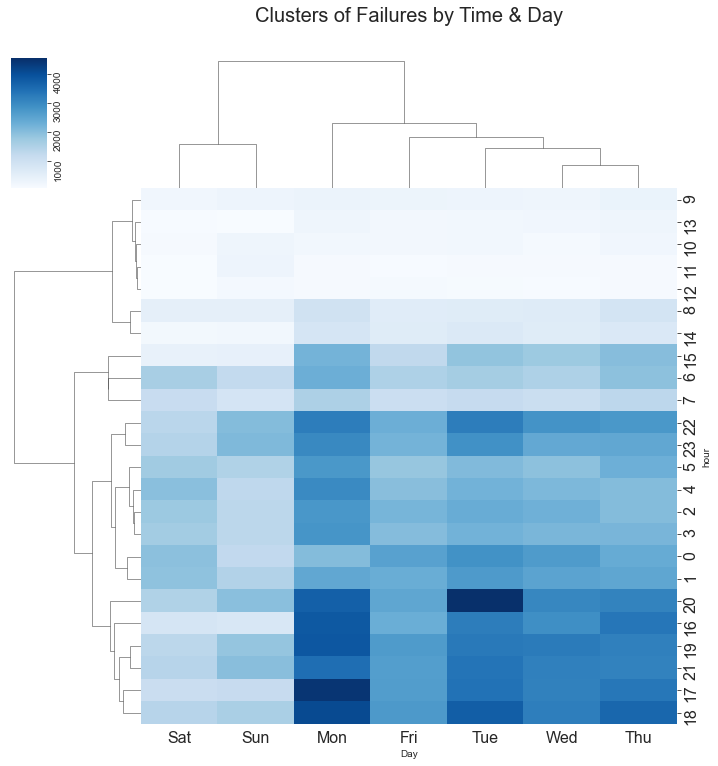

In [245]:
plt.rcParams["figure.figsize"] = (10,20)
g = sns.clustermap(data=failedLoginsByDayAndHour, cmap="Blues", metric="euclidean",method='centroid', yticklabels=True, annot_kws={"size": 29})
g.ax_heatmap.set_title('Clusters of Failures by Time & Day',y=1.3, fontsize=20)
plt.yticks(rotation=90) 
# plt.title('Hierarchical Clustering of Time and Day')

new_labels = []
for l in g.ax_heatmap.axes.get_yticklabels():
    l.set_fontsize(16)
    new_labels.append(l)
g.ax_heatmap.axes.set_yticklabels(new_labels)


new_labels = []
for l in g.ax_heatmap.axes.get_xticklabels():
    l.set_fontsize(16)
    new_labels.append(l)
g.ax_heatmap.axes.set_xticklabels(new_labels)

plt.show()

In [237]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

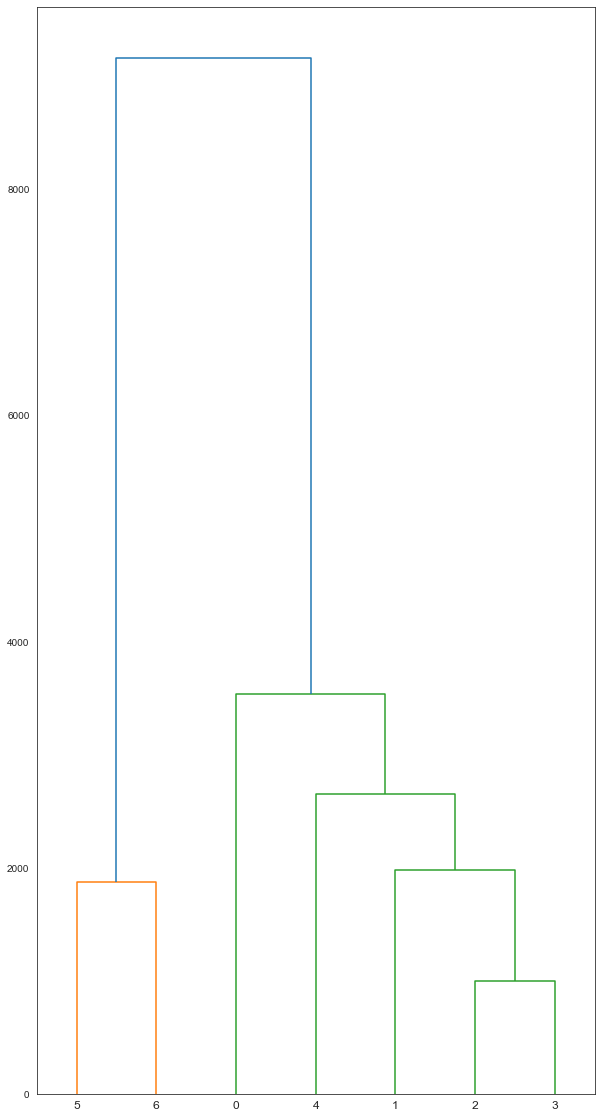

In [238]:
dendrogram = sch.dendrogram(sch.linkage(failedLoginsByDayAndHour.transpose(), method='ward'))

In [569]:
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage='ward')
y_hc = hc.fit_predict(failedLoginsByDayAndHour.transpose())

In [571]:
y_hc

array([0, 0, 0, 0, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 2, 2, 2, 2,
       0, 0], dtype=int64)

In [707]:
cluster = AgglomerativeClustering(n_clusters=None, affinity = 'euclidean', linkage='ward', compute_full_tree=True, distance_threshold=2000)

In [708]:
cluster.fit(failedLoginsByDayAndHour.transpose())

AgglomerativeClustering(compute_full_tree=True, distance_threshold=2000,
                        n_clusters=None)

In [709]:
1+np.amax(cluster.labels_)

6

In [569]:
from sklearn.cluster import KMeans

In [573]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(failedLoginsByDayAndHour.transpose())
    distortions.append(kmeanModel.inertia_)

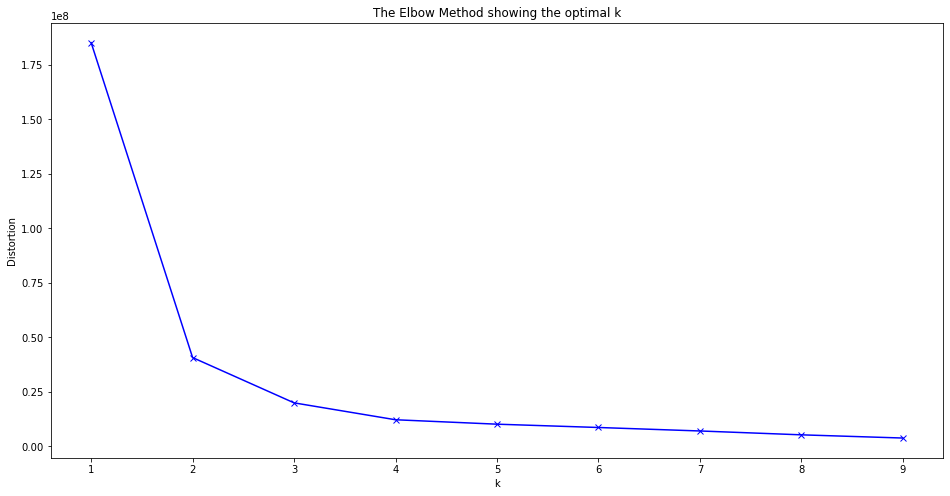

In [574]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [596]:
loginsVsFailureRate = userQuantifiedLogs[['loginTimes','failureRate']]

In [570]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(loginsVsFailureRate)
    distortions.append(kmeanModel.inertia_)

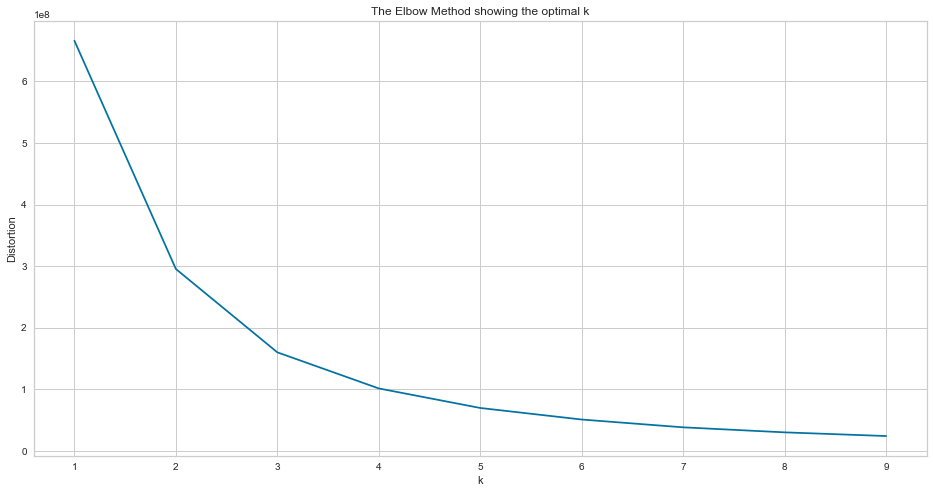

In [571]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [628]:
comparisonOfFailureAndAttempts = userQuantifiedLogs[['loginTimes','failureRate']]

In [625]:

kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(comparisonOfFailureAndAttempts)
distortions.append(kmeanModel.inertia_)
comparisonOfFailureAndAttempts['Clusters'] = kmeanModel.labels_

In [629]:
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage='ward')
y_hc = hc.fit_predict(comparisonOfFailureAndAttempts)

MemoryError: Unable to allocate 4.71 GiB for an array with shape (631847926,) and data type float64

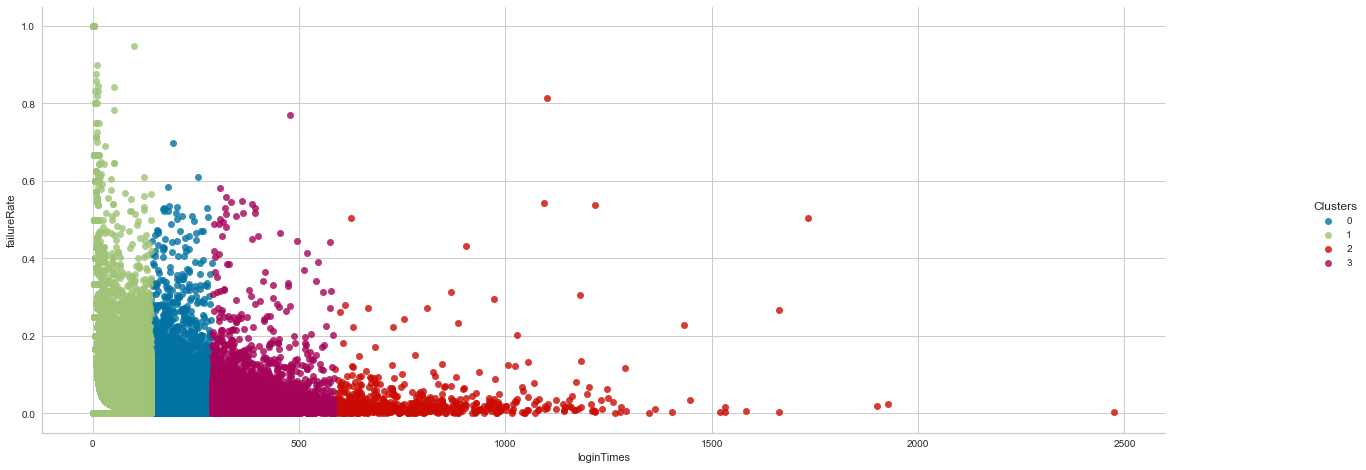

In [626]:
g = sns.lmplot(x='loginTimes', y='failureRate', hue='Clusters', data=comparisonOfFailureAndAttempts, fit_reg=False)
g.fig.set_figwidth(20.27)
g.fig.set_figheight(6.7)
plt.show()

In [ ]:
# Compare the usage of second factors by group

In [293]:
usageOfSecondFactorLogs = logs

In [294]:
usageOfSecondFactorLogs["Description"] = usageOfSecondFactorLogs['Alias'].map(subsetOfUsers.set_index("Alias")["Description"].to_dict())

In [295]:
factorsBeingUsed = usageOfSecondFactorLogs[['Factor','Description','Reason','Alias']]
factorsBeingUsed.head()

,Factor,Description,Reason,Alias
0,Phone Call,Active (Student),User approved,user_008576
1,Duo Push,Active (Student),User approved,user_049277
3,Duo Push,Active (Student),User approved,user_025756
4,Duo Push,Active (Student),User approved,user_030286
5,Duo Push,Active (Student),User approved,user_019093


In [296]:
t = factorsBeingUsed.groupby(['Description','Factor','Alias']).count()

In [297]:
t = factorsBeingUsed.groupby(['Description','Factor','Alias']).count().unstack(level=2).count(axis=1).reset_index()

In [298]:
factorsBeingUsedByGroup = factorsBeingUsed.groupby(['Description','Factor','Alias']).count().unstack(level=2).count(axis=1).unstack(level=1).fillna(0)

In [299]:
factorsBeingUsedByGroup

Factor,Bypass Status,Duo Push,Passcode,Phone Call,Remembered Device,Security Key,Touch ID (WebAuthn)
Description,,,,,,,
Active (Faculty),3.0,1282.0,515.0,730.0,977.0,75.0,4.0
Active (Staff),0.0,810.0,440.0,537.0,792.0,34.0,2.0
Active (Student),15.0,28827.0,8593.0,12846.0,18077.0,10.0,316.0


In [300]:
numberOfUsers = subsetOfUsers["Description"].value_counts().reindex(["Active (Faculty)", "Active (Staff)", "Active (Student)"])
numberOfUsers

Active (Faculty)     1713
Active (Staff)       1143
Active (Student)    32693
Name: Description, dtype: int64

In [301]:
# faculty vs staff
numberOfUsers[0]+ numberOfUsers[1]

2856

In [302]:
# faculty vs students
numberOfUsers[0]+ numberOfUsers[2]

34406

In [303]:
# Staff vs students
numberOfUsers[1]+ numberOfUsers[2]

33836

In [304]:
def computePairWiseChiSquared(dataFrame):
    pVal = .016
    print("Faculty VS Staff")
    print('----------------------------------')
    print(chi2_contingency(dataFrame[['Active (Faculty)','Active (Staff)']]))
    print(chi2_contingency(dataFrame[['Active (Faculty)','Active (Staff)']])[1]<pVal)
#     print(chi2_contingency(dataFrame[['Active (Faculty)','Active (Staff)']]))
    print("φ = " + str(math.sqrt(chi2_contingency(dataFrame[['Active (Faculty)','Active (Staff)']])[0] / (numberOfUsers[0]+ numberOfUsers[1]))))
    print("////////////////")
    print("Faculty VS Student")
    print('----------------------------------')
    print(chi2_contingency(dataFrame[['Active (Faculty)','Active (Student)']]))
    print(chi2_contingency(dataFrame[['Active (Faculty)','Active (Student)']])[1]<pVal)
#     print(chi2_contingency(dataFrame[['Active (Faculty)','Active (Student)']]))
    print("φ = " + str(math.sqrt(chi2_contingency(dataFrame[['Active (Faculty)','Active (Student)']])[0] / (numberOfUsers[0]+ numberOfUsers[2]))))
    print("////////////////")
    print("Staff VS Student")
    print('----------------------------------')
    print(chi2_contingency(dataFrame[['Active (Staff)','Active (Student)']]))
    print(chi2_contingency(dataFrame[['Active (Staff)','Active (Student)']])[1]<pVal)
    print("φ = " + str(math.sqrt(chi2_contingency(dataFrame[['Active (Staff)','Active (Student)']])[0] / (numberOfUsers[1]+ numberOfUsers[2]))))
    
#     print(chi2_contingency(dataFrame[['Active (Staff)','Active (Student)']]))

In [305]:
def createFactorDataFrame(factor):  
    d = { factor + ' Enabled': factorsBeingUsedByGroup[factor]}
    factorUsers = pd.DataFrame(data=d)
    factorUsers[factor+' Not Enabled'] = [numberOfUsers[0]  - factorUsers[factor+' Enabled'][0],
                                          numberOfUsers[1]    - factorUsers[factor+' Enabled'][1],
                                          numberOfUsers[2] - factorUsers[factor+' Enabled'][2]]
    return factorUsers.transpose()

In [306]:
factors = factorsBeingUsedByGroup.columns
percentagesOfFactors = []
for factor in factors:
    if(factor!="Bypass Status"):
        factorUsageDataFrame = createFactorDataFrame(factor)
        print(factorUsageDataFrame)
        print((factorUsageDataFrame.div(numberOfUsers)*100).iloc[0])
        percentagesOfFactors.append((factorUsageDataFrame.div(numberOfUsers)*100).iloc[0].tolist())
        print(factor)
#         break
        print(chi2_contingency(factorUsageDataFrame))
        print('')
        computePairWiseChiSquared(factorUsageDataFrame)
        print('')
print(percentagesOfFactors)

Description           Active (Faculty)  Active (Staff)  Active (Student)
Duo Push Enabled                1282.0           810.0           28827.0
Duo Push Not Enabled             431.0           333.0            3866.0
Description
Active (Faculty)    74.839463
Active (Staff)      70.866142
Active (Student)    88.174839
Name: Duo Push Enabled, dtype: float64
Duo Push
(526.0824796034083, 5.789499771551551e-115, 2, array([[ 1489.89414611,   994.13252131, 28434.97333258],
       [  223.10585389,   148.86747869,  4258.02666742]]))

Faculty VS Staff
----------------------------------
(5.32258254034701, 0.021050790561604915, 1, array([[1254.7605042,  837.2394958],
       [ 458.2394958,  305.7605042]]))
False
φ = 0.04317000519876038
////////////////
Faculty VS Student
----------------------------------
(263.6283148709932, 2.777479019021717e-59, 1, array([[ 1499.06170435, 28609.93829565],
       [  213.93829565,  4083.06170435]]))
True
φ = 0.08753443528499878
////////////////
Staff VS Student
-

In [307]:
percentagesOfFactors

[[74.83946293053123, 70.86614173228347, 88.17483865047564],
 [30.064214827787506, 38.495188101487315, 26.283913987703787],
 [42.61529480443666, 46.981627296587924, 39.292814975682866],
 [57.03444249854057, 69.29133858267717, 55.293182026733554],
 [4.378283712784588, 2.974628171478565, 0.030587587556969383],
 [0.23350846468184472, 0.17497812773403326, 0.9665677668002325]]

In [308]:
factorsBeingUsedByGroup.drop(columns=['Bypass Status'])

Factor,Duo Push,Passcode,Phone Call,Remembered Device,Security Key,Touch ID (WebAuthn)
Description,,,,,,
Active (Faculty),1282.0,515.0,730.0,977.0,75.0,4.0
Active (Staff),810.0,440.0,537.0,792.0,34.0,2.0
Active (Student),28827.0,8593.0,12846.0,18077.0,10.0,316.0


In [309]:
d = {'Bypass Code': percentagesOfFactors[0],
     'Duo Mobile \n Passcode': percentagesOfFactors[1], 
     'Duo Push': percentagesOfFactors[2], 
     'Hardware \n Token':percentagesOfFactors[3], 
     "Phone Call": percentagesOfFactors[5],
     'Remembered \n Device': percentagesOfFactors[6], 
     'Security Key': percentagesOfFactors[7], 
     'Touch ID \n (WebAuthn)': percentagesOfFactors[8],
     "U2F Token": percentagesOfFactors[9],
     "Yubikey \n Passcode": percentagesOfFactors[10]}
factorsBeingUsed = pd.DataFrame(data=d, index=['Faculty', 'Staff', 'Student'])
factorsBeingUsed

IndexError: list index out of range

In [ ]:
sns.set(font_scale = 1.2)
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.heatmap(factorsBeingUsed.drop(columns=['Bypass Code']),cmap='Blues', annot = True, linewidth=1, linecolor="black", annot_kws={"size": 16})
for t in ax.texts: t.set_text(t.get_text() + " %")
plt.yticks(rotation=0, fontsize=16)
plt.xticks(rotation=0, fontsize=13.5)
plt.title('Usage of Factors by Faculty, Staff, & Students', fontsize=24)
plt.show()

# Compare the usage of enabling a backup device by group (student, faculty, staff)?

In [132]:
def enabledBackup(factor):
    if(factor!=0):
        return 1
    else:
        return 0

In [133]:
anlysisOfUsers = subsetOfUsers.fillna(0)

In [134]:
anlysisOfUsers['Backup enabled'] = anlysisOfUsers['Phone 2 platform'].apply(lambda val: enabledBackup(val))

In [135]:
t = anlysisOfUsers.groupby(['Description','Backup enabled']).size().unstack().transpose()

In [136]:
t

Description,Active (Faculty),Active (Staff),Active (Student)
Backup enabled,,,
0,1527,744,30547
1,186,399,2146


In [143]:
t.sum(axis=1)[1] / t.sum(axis=1)[0]*100 - 100

-91.67834724846121

In [46]:
print(chi2_contingency(t))

(1276.6199010544447, 6.10254150835391e-278, 2, array([[ 1581.40127711,  1055.19069453, 30181.40802836],
       [  131.59872289,    87.80930547,  2511.59197164]]))


In [75]:
computePairWiseChiSquared(t)

Faculty VS Staff
----------------------------------
(241.98065529842685, 1.4549279994841732e-54, 1, array([[1362.12289916,  908.87710084],
       [ 350.87710084,  234.12289916]]))
True
φ = 0.29107923354738036
////////////////
Faculty VS Student
----------------------------------
(46.82334389647097, 7.768255120726826e-12, 1, array([[ 1596.89478579, 30477.10521421],
       [  116.10521421,  2215.89478579]]))
True
φ = 0.03689046422226138
////////////////
Staff VS Student
----------------------------------
(1271.474915691436, 1.7872091659174707e-278, 1, array([[ 1057.0284017, 30233.9715983],
       [   85.9715983,  2459.0284017]]))
True
φ = 0.19384936832635574


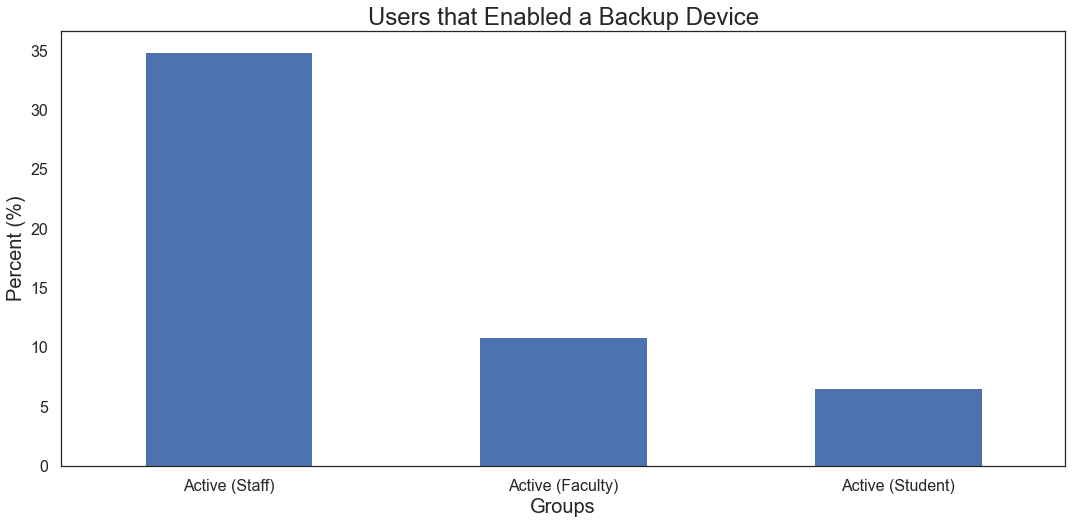

In [555]:
i = t.transpose()[1].div(t.transpose().sum(axis=1))*100
i.sort_values(ascending=False).plot.bar(rot=0)
plt.ylabel('Percent (%)', fontsize=20)
plt.xlabel('Groups', fontsize=20)
plt.title('Users that Enabled a Backup Device', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

# Recovery time

In [246]:
recoveryTimeOfUsers = pd.read_csv("allOfUsersRecoveryTime.csv", index_col=None, header=0)

In [247]:
recoveryTimeOfUsers.shape

(50962, 4)

In [248]:
recoveryTimeOfUsers = recoveryTimeOfUsers[recoveryTimeOfUsers['user'].isin(subsetOfUsers["Alias"])]

In [249]:
recoveryTimeOfUsers.shape

(35549, 4)

In [250]:
recoveryTimeOfUsers = recoveryTimeOfUsers.iloc[:,:2]
recoveryTimeOfUsers.head()

,user,recovery_time
0,user_000001,19.417176
1,user_000002,30067.634786
2,user_000003,345.067032
3,user_000004,5.262786
4,user_000005,164.743175


In [251]:
recoveryTimeOfUsers.sort_values(by='recovery_time', inplace=True)

In [252]:
recoveryTimeOfUsers.insert(0,'New_ID', range(1, len(recoveryTimeOfUsers)+1))

recoveryTimeOfUsers['userPercentage'] = recoveryTimeOfUsers['New_ID'].apply(lambda num: num/len(recoveryTimeOfUsers))

In [253]:
recoveryTimeOfUsers["recovery_time"].describe()

count    3.554900e+04
mean     3.152124e+04
std      2.052254e+05
min      0.000000e+00
25%      1.936032e+01
50%      4.037203e+02
75%      1.692875e+04
max      1.159507e+07
Name: recovery_time, dtype: float64

In [254]:
recoveryTimeOfUsers['userPercentage'] = recoveryTimeOfUsers['userPercentage']*100

In [255]:
recoveryTimeOfUsers['recovery_time'].skew()

27.205837728177098

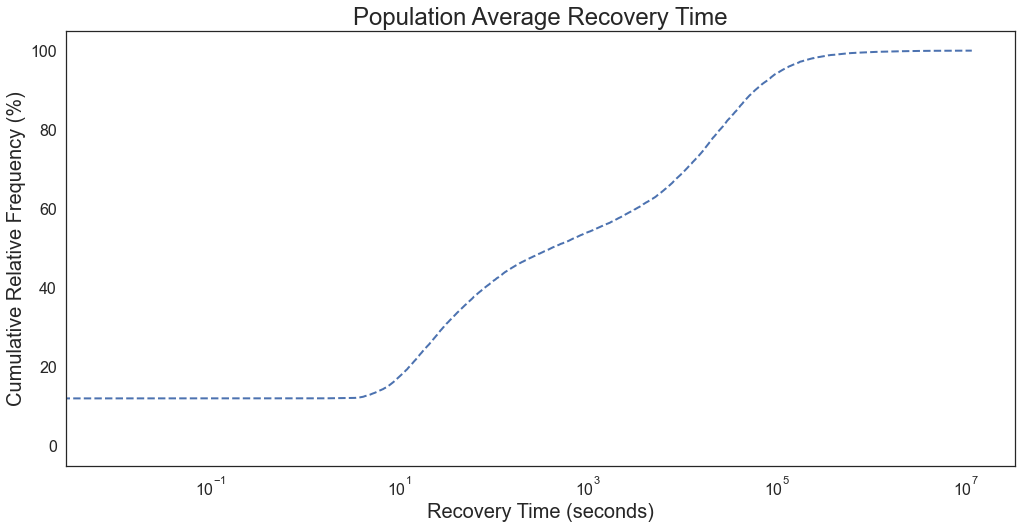

In [265]:
sns.set(font_scale = 2)
sns.set_style("white")
plt.rcParams["figure.figsize"] = (17,8)
ax = recoveryTimeOfUsers.plot(x='recovery_time', y='userPercentage', legend=False, ls = '--', lw = 2)
plt.ylabel('Cumulative Relative Frequency (%)', fontsize=20)
plt.xlabel('Recovery Time (seconds)', fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.set_xscale('log')

plt.title("Population Average Recovery Time", fontsize=24)

plt.show()

In [257]:
userQuantifiedLogs["recoveryTime"] = userQuantifiedLogs.index.map(recoveryTimeOfUsers.set_index("user")["recovery_time"].to_dict())

In [258]:
stats.kruskal(userQuantifiedLogs[userQuantifiedLogs["Description"]=="Active (Student)"]["recoveryTime"],
              userQuantifiedLogs[userQuantifiedLogs["Description"]=="Active (Faculty)"]["recoveryTime"],
              userQuantifiedLogs[userQuantifiedLogs["Description"]=="Active (Staff)"]["recoveryTime"])

KruskalResult(statistic=114.98674748361914, pvalue=1.0738535023818803e-25)

In [259]:
res = sp.posthoc_dscf([userQuantifiedLogs[userQuantifiedLogs["Description"]=="Active (Student)"]["recoveryTime"],
                       userQuantifiedLogs[userQuantifiedLogs["Description"]=="Active (Faculty)"]["recoveryTime"],
                       userQuantifiedLogs[userQuantifiedLogs["Description"]=="Active (Staff)"]["recoveryTime"]]).rename(index={1: "students", 2: "faculty", 3: "staff"}, columns={1: "students", 2: "faculty", 3: "staff"})
res

,students,faculty,staff
students,1.000,0.001000,0.001000
faculty,0.001,1.000000,0.576912
staff,0.001,0.576912,1.000000


In [260]:
d, cliff_res = cliffs_delta(userQuantifiedLogs[userQuantifiedLogs['Description']=="Active (Student)"]['recoveryTime'], 
                userQuantifiedLogs[userQuantifiedLogs['Description']=="Active (Faculty)"]['recoveryTime'])
print(d, cliff_res)

0.11373304292802744 negligible


In [261]:
d, cliff_res = cliffs_delta(userQuantifiedLogs[userQuantifiedLogs['Description']=="Active (Student)"]['recoveryTime'], 
                userQuantifiedLogs[userQuantifiedLogs['Description']=="Active (Staff)"]['recoveryTime'])
print(d, cliff_res)

0.13034984733903643 negligible


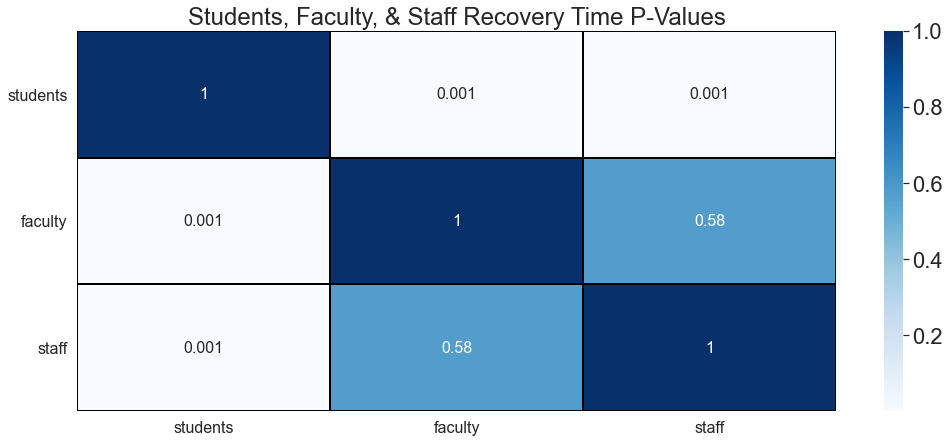

In [268]:
plt.rcParams["figure.figsize"] = (17,7)
sns.heatmap(res,cmap='Blues', linewidths = 0.30, annot = True, linewidth=1, linecolor="black", annot_kws={"size": 16})
plt.yticks(rotation=0) 
plt.title('Students, Faculty, & Staff Recovery Time P-Values', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

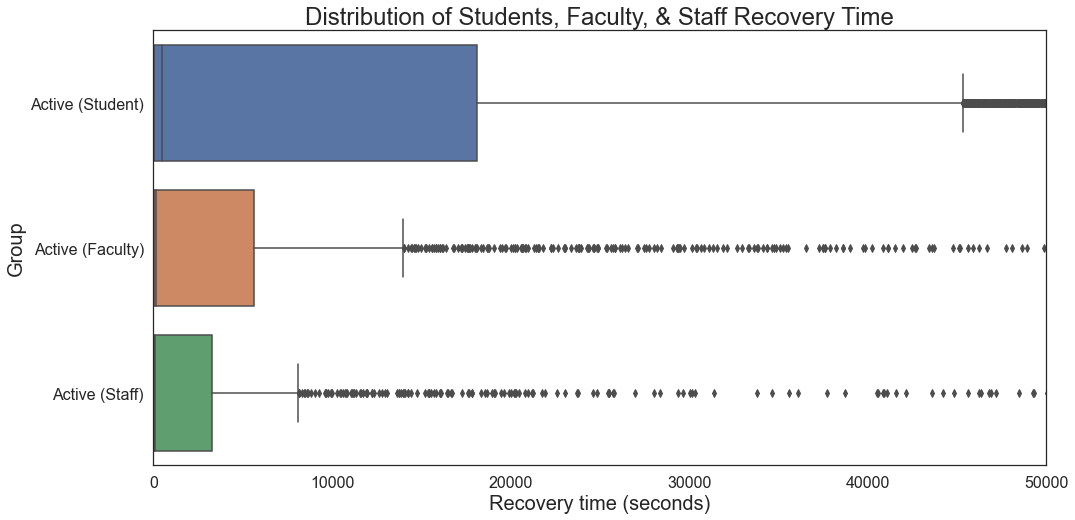

In [272]:
plt.rcParams["figure.figsize"] = (16,8)
sns.boxplot(y="Description", x="recoveryTime", orient='h', data=userQuantifiedLogs)
plt.xlabel('Recovery time (seconds)', fontsize=20)
plt.ylabel('Group', fontsize=20)
plt.title('Distribution of Students, Faculty, & Staff Recovery Time', fontsize=24)
plt.xlim(0,50000)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [267]:
plt.rcParams["figure.figsize"] = (8,10)
sns.boxplot(x="backup", y="recoveryTime", data=userQuantifiedLogs)
plt.ylabel('Recovery time (seconds)')
plt.xlabel('Backup Device')
plt.title('Recovery Time Between Groups')
plt.ylim(0,50000)
plt.show()

ValueError: Could not interpret input 'backup'

In [398]:
from scipy.stats import mannwhitneyu
res = mannwhitneyu(userQuantifiedLogs[userQuantifiedLogs['backup']==False]['recoveryTime'], 
                userQuantifiedLogs[userQuantifiedLogs['backup']==True]['recoveryTime'])
res

MannwhitneyuResult(statistic=40760287.0, pvalue=1.7473894102769366e-15)

In [302]:
d, cliff_res = cliffs_delta(userQuantifiedLogs[userQuantifiedLogs['backup']==False]['recoveryTime'], 
                userQuantifiedLogs[userQuantifiedLogs['backup']==True]['recoveryTime'])
print(d, cliff_res)

-0.09043567489677488 negligible


# Compare Failure Rate in first 10 attmepts

In [121]:
# Users Created after november
usersCreatedAfterNovember = subsetOfUsers[subsetOfUsers['Created']>'2020-11-01']
usersCreatedAfterNovember.shape

(953, 14)

In [122]:
usersCreatedAfterNovember.Description.value_counts() / usersCreatedAfterNovember.shape[0]*100

Active (Student)    96.327387
Active (Staff)       2.308499
Active (Faculty)     1.364113
Name: Description, dtype: float64

In [123]:
enrollmentAnlysisLogs = logs[logs['Alias'].isin(usersCreatedAfterNovember.set_index("Alias")["Description"].to_dict())]

In [124]:
enrollmentAnlysisLogs = enrollmentAnlysisLogs[enrollmentAnlysisLogs['Reason']!='Remembered device']
enrollmentAnlysisLogs = enrollmentAnlysisLogs[enrollmentAnlysisLogs['Reason']!='Allow unenrolled user']
enrollmentAnlysisLogs = enrollmentAnlysisLogs[enrollmentAnlysisLogs['Reason']!='User is disabled']
enrollmentAnlysisLogs = enrollmentAnlysisLogs[enrollmentAnlysisLogs['Reason']!='Bypass user']
enrollmentAnlysisLogs = enrollmentAnlysisLogs[enrollmentAnlysisLogs['Reason'].notna()]
enrollmentAnlysisLogs.set_index('Alias', inplace=True)

In [125]:
print(usersCreatedAfterNovember.shape, enrollmentAnlysisLogs.index.unique().shape)

(953, 14) (952,)


In [126]:
usersCreatedAfterNovemberWithLogs = enrollmentAnlysisLogs.index.unique()

In [127]:
usersCreatedAfterNovemberWithLogs

Index(['user_051552', 'user_051724', 'user_053223', 'user_051708',
       'user_051770', 'user_052010', 'user_051621', 'user_052488',
       'user_052018', 'user_051565',
       ...
       'user_051596', 'user_051628', 'user_051618', 'user_051592',
       'user_051202', 'user_051197', 'user_051922', 'user_052019',
       'user_051949', 'user_051590'],
      dtype='object', name='Alias', length=952)

In [128]:
def addToDataFrame(data):
    df_length = len(userEnrollmentLogs)
    userEnrollmentLogs.loc[df_length] = data

In [129]:
userEnrollmentLogs = pd.DataFrame(columns=['user','1','2','3','4','5','6','7','8','9','10'])
# success and failure data

# users who have authenticated at least 10 times
usersWithTenAuth = []

for user in usersCreatedAfterNovemberWithLogs[:]:
    array = []
    counter = 0
    errorRate = 0
    failures = 0
    if(len(enrollmentAnlysisLogs.loc[user]['Result'])<10):
        continue
    usersWithTenAuth.append(user)
    for i in enrollmentAnlysisLogs.loc[user]['Reason']:
        counter += 1
        array.append(i)
        if(counter==10):
            break
#     print(enrollmentAnlysisLogs.loc[user].Description)
    array.insert(0,user)
    addToDataFrame(array)

In [130]:
userEnrollmentLogs["Description"] = userEnrollmentLogs.user.map(subsetOfUsers.set_index("Alias")["Description"].to_dict())

In [131]:
userEnrollmentLogs.shape

(747, 12)

In [132]:
userEnrollmentLogs['Description'].value_counts() / userEnrollmentLogs.shape[0]*100

Active (Student)    96.653280
Active (Staff)       2.409639
Active (Faculty)     0.937082
Name: Description, dtype: float64

In [133]:
userEnrollmentLogs.Description.value_counts()

Active (Student)    722
Active (Staff)       18
Active (Faculty)      7
Name: Description, dtype: int64

In [134]:
userEnrollmentLogs.iloc[1:,:11].head(10)

,user,1,2,3,4,5,6,7,8,9,10
1,user_051724,No response,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved
2,user_053223,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved
3,user_051708,User approved,User approved,User approved,User approved,User cancelled,User approved,User approved,User approved,User cancelled,Valid passcode
4,user_051770,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved
5,user_052010,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved
6,user_051621,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved
7,user_052488,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved
8,user_052018,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved
9,user_051565,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved,User approved
10,user_053257,User approved,User approved,User approved,No response,User approved,User approved,User approved,User approved,No response,User cancelled


In [135]:
userEnrollmentLogs.iloc[:,1:11].melt()['value'].value_counts().sort_values(ascending=False)[2:] / userEnrollmentLogs.iloc[:,1:11].melt()['value'].value_counts().sort_values(ascending=False)[2:].sum()*100

User cancelled      46.881288
No response         39.637827
Invalid passcode    10.060362
Call timed out       1.810865
No keys pressed      1.408451
User mistake         0.201207
Name: value, dtype: float64

In [136]:
failiureAndSuccessTerms = {
    "User approved": 1,       
    "Valid passcode": 1,                
    "Invalid passcode": 0,      
    "No keys pressed": 0,        
    "Call timed out": 0,                    
    "Locked out": 0,
    "User mistake": 0,
    "No response": 0,
    "User cancelled": 0
}

In [137]:
enrollmentLogsWithTerms = userEnrollmentLogs.replace(failiureAndSuccessTerms)     
enrollmentLogsWithTerms.shape

(747, 12)

In [138]:
enrollmentLogsWithTerms["initialSuccessRate"] = enrollmentLogsWithTerms.iloc[:,1:11].sum(axis = 1)/10*100

In [139]:
enrollmentLogsWithTerms.head()

,user,1,2,3,4,5,6,7,8,9,10,Description,initialSuccessRate
0,user_051552,1,1,0,1,1,1,1,1,0,1,Active (Student),80.0
1,user_051724,0,1,1,1,1,1,1,1,1,1,Active (Student),90.0
2,user_053223,1,1,1,1,1,1,1,1,1,1,Active (Student),100.0
3,user_051708,1,1,1,1,0,1,1,1,0,1,Active (Student),80.0
4,user_051770,1,1,1,1,1,1,1,1,1,1,Active (Student),100.0


In [140]:
enrollmentLogsWithTerms['firstSuccessRate'] = enrollmentLogsWithTerms['1'].apply(lambda val: val/1*100)
enrollmentLogsWithTerms['secondSuccessRate'] = enrollmentLogsWithTerms.iloc[:,1:3].sum(axis = 1)/2*100
enrollmentLogsWithTerms['thirdSuccessRate'] = enrollmentLogsWithTerms.iloc[:,1:4].sum(axis = 1)/3*100
enrollmentLogsWithTerms['fourthSuccessRate'] = enrollmentLogsWithTerms.iloc[:,1:5].sum(axis = 1)/4*100
enrollmentLogsWithTerms['fifthSuccessRate'] = enrollmentLogsWithTerms.iloc[:,1:6].sum(axis = 1)/5*100
enrollmentLogsWithTerms['sixthSuccessRate'] = enrollmentLogsWithTerms.iloc[:,1:7].sum(axis = 1)/6*100
enrollmentLogsWithTerms['seventhSuccessRate'] = enrollmentLogsWithTerms.iloc[:,1:8].sum(axis = 1)/7*100
enrollmentLogsWithTerms['eightSuccessRate'] = enrollmentLogsWithTerms.iloc[:,1:9].sum(axis = 1)/8*100
enrollmentLogsWithTerms['ninethSuccessRate'] = enrollmentLogsWithTerms.iloc[:,1:10].sum(axis = 1)/9*100
enrollmentLogsWithTerms['tenthSuccessRate'] = enrollmentLogsWithTerms.iloc[:,1:11].sum(axis = 1)/10*100

In [141]:
enrollmentLogsWithTerms.head()

,user,1,2,3,4,5,6,7,8,9,10,Description,initialSuccessRate,firstSuccessRate,secondSuccessRate,thirdSuccessRate,fourthSuccessRate,fifthSuccessRate,sixthSuccessRate,seventhSuccessRate,eightSuccessRate,ninethSuccessRate,tenthSuccessRate
0,user_051552,1,1,0,1,1,1,1,1,0,1,Active (Student),80.0,100.0,100.0,66.666667,75.0,80.0,83.333333,85.714286,87.5,77.777778,80.0
1,user_051724,0,1,1,1,1,1,1,1,1,1,Active (Student),90.0,0.0,50.0,66.666667,75.0,80.0,83.333333,85.714286,87.5,88.888889,90.0
2,user_053223,1,1,1,1,1,1,1,1,1,1,Active (Student),100.0,100.0,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.0,100.000000,100.0
3,user_051708,1,1,1,1,0,1,1,1,0,1,Active (Student),80.0,100.0,100.0,100.000000,100.0,80.0,83.333333,85.714286,87.5,77.777778,80.0
4,user_051770,1,1,1,1,1,1,1,1,1,1,Active (Student),100.0,100.0,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.0,100.000000,100.0


In [142]:
enrollmentLogsWithTerms[enrollmentLogsWithTerms['Description']=='Active (Student)'][['Description','initialSuccessRate']].skew()

<ipython-input-142-cc1262c5fcfa>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  enrollmentLogsWithTerms[enrollmentLogsWithTerms['Description']=='Active (Student)'][['Description','initialSuccessRate']].skew()


initialSuccessRate   -3.234589
dtype: float64

In [143]:
enrollmentLogsWithTerms[enrollmentLogsWithTerms['Description']=='Active (Faculty)'][['Description','initialSuccessRate']].skew()

<ipython-input-143-5275014abde8>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  enrollmentLogsWithTerms[enrollmentLogsWithTerms['Description']=='Active (Faculty)'][['Description','initialSuccessRate']].skew()


initialSuccessRate   -2.191928
dtype: float64

In [144]:
enrollmentLogsWithTerms[enrollmentLogsWithTerms['Description']=='Active (Staff)'][['Description','initialSuccessRate']].skew()

<ipython-input-144-c1a1e7e21f4e>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  enrollmentLogsWithTerms[enrollmentLogsWithTerms['Description']=='Active (Staff)'][['Description','initialSuccessRate']].skew()


initialSuccessRate   -1.438224
dtype: float64

In [145]:
initialMeanSuccessRate = enrollmentLogsWithTerms.iloc[:,11:24].groupby(['Description']).mean().iloc[:,1:].transpose() 

In [55]:
initialMeanSuccessRate

Description,Active (Faculty),Active (Staff),Active (Student)
firstSuccessRate,71.428571,88.888889,94.321330
secondSuccessRate,78.571429,91.666667,94.736842
thirdSuccessRate,80.952381,94.444444,93.998153
fourthSuccessRate,82.142857,93.055556,94.182825
fifthSuccessRate,82.857143,92.222222,94.072022
sixthSuccessRate,83.333333,90.740741,93.905817
seventhSuccessRate,83.673469,90.476190,93.826672
eightSuccessRate,83.928571,90.972222,93.646122
ninethSuccessRate,82.539683,90.740741,93.551862
tenthSuccessRate,84.285714,91.111111,93.490305


In [56]:
res = adfuller(initialMeanSuccessRate['Active (Faculty)'], autolag='AIC')
print(f'ADF Statistic: {res[0]}')
print(f'p-value: {res[1]}')
for key, value in res[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.742737634920973
p-value: 0.4092380695423334
Critial Values:
   1%, -5.354256481481482
Critial Values:
   5%, -3.6462381481481483
Critial Values:
   10%, -2.901197777777778


In [57]:
tau, p_value = stats.kendalltau([i for i in range(1,len(initialMeanSuccessRate['Active (Faculty)'])+1)], initialMeanSuccessRate['Active (Faculty)'])
print(tau, p_value)

0.8222222222222221 0.0003576940035273369


In [58]:
res = adfuller(initialMeanSuccessRate['Active (Staff)'], autolag='AIC')
print(f'ADF Statistic: {res[0]}')
print(f'p-value: {res[1]}')
for key, value in res[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.834557509528564
p-value: 4.6684965961726e-05
Critial Values:
   1%, -4.9386902332361515
Critial Values:
   5%, -3.477582857142857
Critial Values:
   10%, -2.8438679591836733


In [59]:
tau, p_value = stats.kendalltau([i for i in range(1,len(initialMeanSuccessRate['Active (Staff)'])+1)], initialMeanSuccessRate['Active (Staff)'])
print(tau, p_value)

-0.13483997249264842 0.590013887163346


In [60]:
res = adfuller(initialMeanSuccessRate['Active (Student)'], autolag='AIC')
print(f'ADF Statistic: {res[0]}')
print(f'p-value: {res[1]}')
for key, value in res[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.0183233764740063
p-value: 0.7465227446246174
Critial Values:
   1%, -4.473135048010974
Critial Values:
   5%, -3.28988060356653
Critial Values:
   10%, -2.7723823456790124


In [61]:
tau, p_value = stats.kendalltau([i for i in range(1,len(initialMeanSuccessRate['Active (Student)'])+1)], initialMeanSuccessRate['Active (Student)'])
print(tau, p_value)

-0.8666666666666666 0.00011518959435626102


In [146]:
initialMeanSuccessRate = initialMeanSuccessRate.rename(index={"firstSuccessRate": 1,
                                     "secondSuccessRate": 2,
                                    "thirdSuccessRate": 3,
                                    "fourthSuccessRate": 4,
                                    "fifthSuccessRate": 5,
                                    "sixthSuccessRate": 6,
                                    "seventhSuccessRate": 7,
                                    "eightSuccessRate": 8,
                                    "ninethSuccessRate": 9,
                                    "tenthSuccessRate": 10})

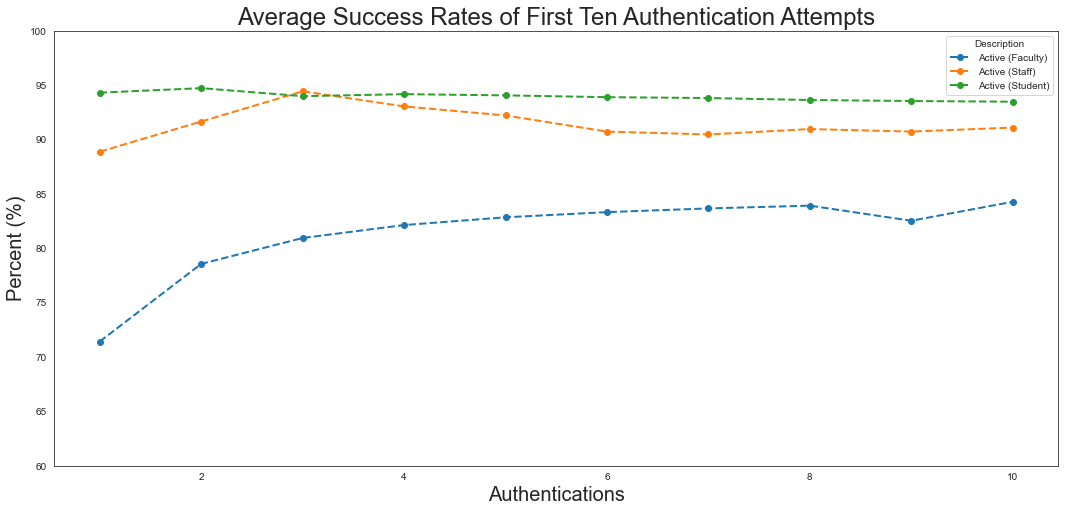

In [186]:
# sns.set(font_scale = 1.5)
sns.set_style("white")
plt.rcParams["figure.figsize"] = (18,8)
initialMeanSuccessRate.plot(ls = 'dashed', lw = 2, marker = 'o')
plt.title("Average Success Rates of First Ten Authentication Attempts", fontsize=24)
plt.ylabel('Percent (%)', fontsize=20)
plt.xlabel('Authentications', fontsize=20)
plt.ylim(60,100)
plt.show()

In [77]:
g1 = enrollmentLogsWithTerms[enrollmentLogsWithTerms["Description"]=="Active (Student)"]["initialSuccessRate"]
g2 = enrollmentLogsWithTerms[enrollmentLogsWithTerms["Description"]=="Active (Staff)"]["initialSuccessRate"]
g3 = enrollmentLogsWithTerms[enrollmentLogsWithTerms["Description"]=="Active (Faculty)"]["initialSuccessRate"]

In [78]:
stats.shapiro(enrollmentLogsWithTerms["initialSuccessRate"])
# not normally distributed 

ShapiroResult(statistic=0.5635210871696472, pvalue=1.764028775710689e-39)

In [79]:
res = stats.kruskal(g1, g2, g3)
print(res, res[1]<.05)

KruskalResult(statistic=3.5311565173511164, pvalue=0.17108782485598292) False


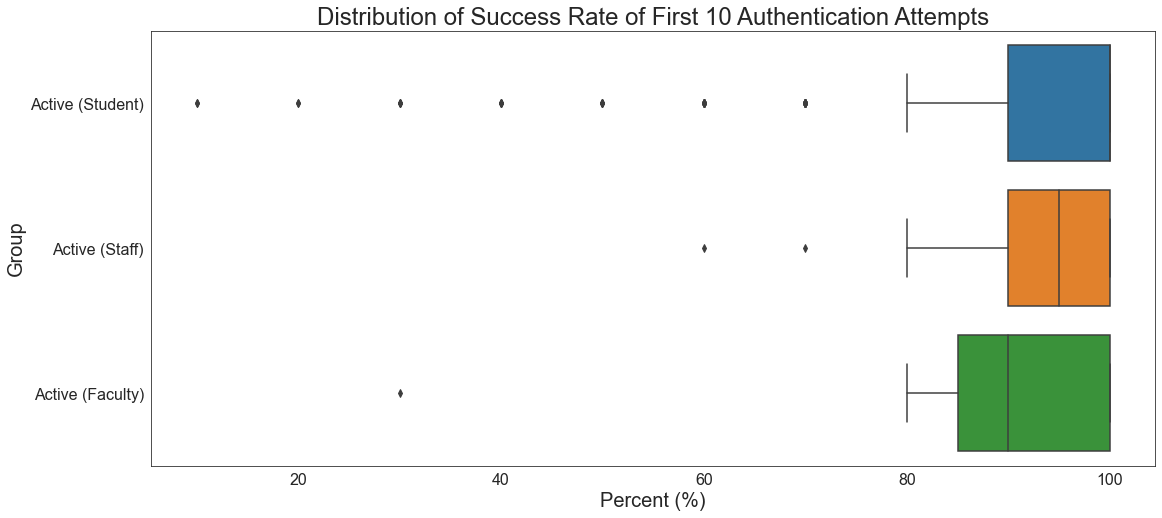

In [187]:
# sns.set(font_scale = 1.3)
from cycler import cycler
sns.set_style("white")
plt.rcParams["figure.figsize"] = (18,8)
# plt.rc('axes', prop_cycle=(cycler('color', ['#2ca02c', '#ff7f0e', '#1f77b4'])))

sns.boxplot(y="Description", x="initialSuccessRate", orient='h', data=enrollmentLogsWithTerms)
plt.title('Distribution of Success Rate of First 10 Authentication Attempts', fontsize=24)
plt.ylabel('Group', fontsize=20)
plt.xlabel('Percent (%)', fontsize=20)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()

In [453]:
enrollmentLogsWithTerms.iloc[:,1:11].sum(axis=1).value_counts()[10] / enrollmentLogsWithTerms.iloc[:,1:11].sum(axis=1).value_counts().sum() * 100

63.85542168674698

# compare the usage of each factor over time

In [127]:
logs_by_factor = logs

In [128]:
logs_by_factor_users = logs_by_factor.groupby(['month','Alias','Factor']).size()

In [129]:
i = logs_by_factor_users.unstack(level=2).fillna(0)

In [130]:
def hasUsedFactor(num):
    if(num>0):
        return 1
    else:
        return 0

In [131]:
i = i.applymap(lambda x: hasUsedFactor(x))

In [132]:
g = i.reset_index()

In [133]:
numberOfPeoplePerMonth = g.groupby(['month']).size()
numberOfPeoplePerMonth = numberOfPeoplePerMonth.reindex([11,12,1,2,3,4]).rename( index={11: 'November', 12: 'December', 1: 'January', 2: 'Febuary', 3: 'March', 4: 'April'})

In [134]:
h = g

In [135]:
dataFramee = pd.DataFrame(columns=h.columns[2:])
dataFramee

Factor,Bypass Code,Bypass Status,Duo Mobile Passcode,Duo Push,Hardware Token,Passcode,Phone Call,Remembered Device,Security Key (WebAuthn),Touch ID (WebAuthn),U2F Token,Yubikey Passcode


In [136]:
months = [11,12,1,2,3,4]
for i in months:
    row = []
    for j in h.columns:
        if(j!='month' and j!='Alias'):
#             print(i, j)
            d = h[h['month']==i][j].sum()
            row.append(d)
    tempDF = pd.DataFrame(data=np.array([row]),columns=h.columns[2:],index = [i])
    dataFramee = pd.concat([dataFramee, tempDF])

In [137]:
dataFrameeRanamed = dataFramee.rename( index={11: 'November', 12: 'December', 1: 'January', 2: 'Febuary', 3: 'March', 4: 'April'})
dataFrameeRanamed

Factor,Bypass Code,Bypass Status,Duo Mobile Passcode,Duo Push,Hardware Token,Passcode,Phone Call,Remembered Device,Security Key (WebAuthn),Touch ID (WebAuthn),U2F Token,Yubikey Passcode
November,65,13,4040,27692,447,1419,7789,14964,27,230,74,0
December,38,11,3188,27597,438,1015,7434,14140,30,223,81,0
January,39,8,3127,28495,454,1084,7948,15112,29,240,84,1
Febuary,48,8,2863,27271,440,1006,7260,15456,29,240,87,1
March,45,8,2525,26847,439,885,7239,14851,27,250,79,2
April,41,8,2545,26902,412,920,7309,15493,26,241,78,0


In [138]:
dataFrameeRanamed = dataFrameeRanamed.div(numberOfPeoplePerMonth, axis='index')*100

In [139]:
dataFrameeRanamed.drop(columns=["Bypass Status","Passcode","Bypass Code"], inplace=True)

In [140]:
dataFrameeRanamed.columns[0]

'Duo Mobile Passcode'

In [146]:
for i in dataFrameeRanamed.columns:
    print(i)
    print(dataFrameeRanamed[i])
    res = adfuller(dataFrameeRanamed[i], autolag='AIC')
    print(' ')
#     print(f'ADF Statistic: {res[0]}')
#     print(f'p-value: {res[1]}')
#     for key, value in res[4].items():
#         print('Critial Values:')
#         print(f'   {key}, {value}')
    
    tau, p_value = stats.kendalltau([i for i in range(1,len(dataFrameeRanamed[i])+1)], dataFrameeRanamed[i])
    print(tau, p_value)
    print('')
    print('')

Duo Mobile Passcode
November    11.923735
December     9.448446
January      9.130194
Febuary      8.547544
March        7.588508
April        7.673521
Name: Duo Mobile Passcode, dtype: object
 
-0.8666666666666666 0.016666666666666666


Duo Push
November    81.730712
December      81.7907
January     83.199509
Febuary     81.418122
March       80.684619
April       81.113188
Name: Duo Push, dtype: object
 
-0.4666666666666666 0.2722222222222222


Hardware Token
November    1.319285
December    1.298124
January     1.325586
Febuary     1.313629
March       1.319348
April       1.242236
Name: Hardware Token, dtype: object
 
-0.2 0.7194444444444444


Phone Call
November    22.988608
December    22.032542
January     23.206517
Febuary     21.674877
March       21.755725
April       22.037629
Name: Phone Call, dtype: object
 
-0.2 0.7194444444444444


Remembered Device
November    44.165043
December    41.907472
January     44.123916
Febuary     46.144201
March       44.632446
April       

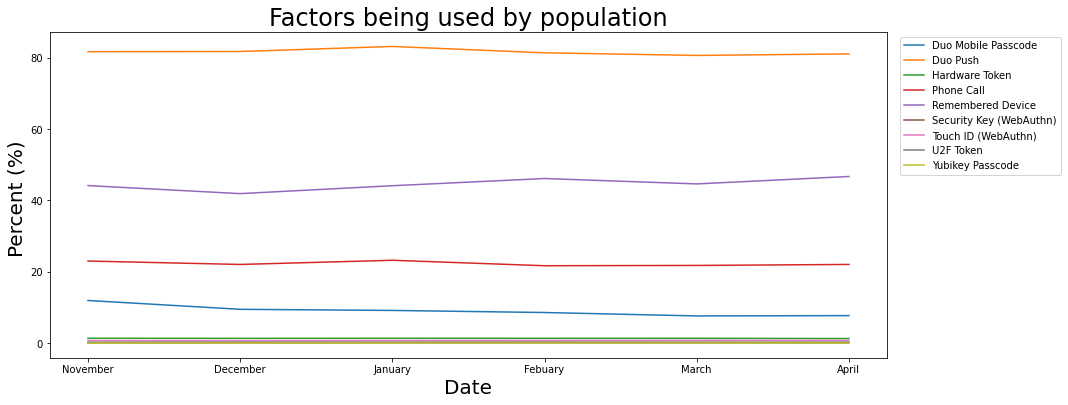

In [859]:
dataFrameeRanamed.plot()
plt.ylabel('Percent (%) ', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.title('Factors being used by population', fontsize=24)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.show()

In [ ]:
# anlyze sucess vs failures

In [478]:
successVsFailures = logs

In [479]:
successVsFailures = successVsFailures.groupby(["date","Result"]).size().unstack()

In [480]:
successVsFailures.drop(columns=["FRAUD"]).corr()

Result,FAILURE,SUCCESS
Result,,
FAILURE,1.000000,0.914016
SUCCESS,0.914016,1.000000


In [351]:
successVsFailures.head(1)

Result,FAILURE,FRAUD,SUCCESS
date,,,
2020-11-01,687.0,NaN,12484.0


In [481]:
from sklearn.linear_model import LinearRegression

In [482]:
X = successVsFailures['SUCCESS'].values.reshape(-1, 1)
Y = successVsFailures['FAILURE'].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

In [483]:
r_sq = linear_regressor.score(X, Y)
>>> print('coefficient of determination:', r_sq)

coefficient of determination: 0.8354259611857024


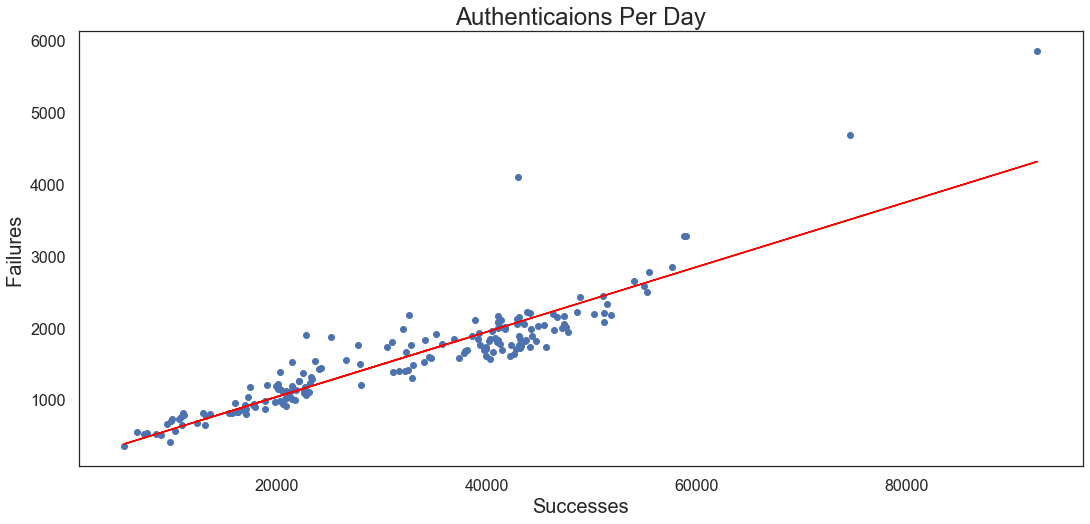

In [543]:
# sns.set(font_scale = 2)
sns.set_style("white")
plt.rcParams["figure.figsize"] = (18,8)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.ylabel('Failures ', fontsize=20)
plt.xlabel('Successes', fontsize=20)
plt.title('Authenticaions Per Day', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [487]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     908.7
Date:                Mon, 21 Mar 2022   Prob (F-statistic):           4.76e-72
Time:                        16:29:57   Log-Likelihood:                -1284.0
No. Observations:                 181   AIC:                             2572.
Df Residuals:                     179   BIC:                             2578.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        138.0998     52.767      2.617      0.0

In [ ]:
# compute the correlation betw

In [82]:
userQuantifiedLogs.head()

Result,New_ID,FAILURE,SUCCESS,failureRate,userPercentage,loginTimes,quartile,Description,backup,Phone 1 platform
Alias,,,,,,,,,,
user_025618,1,0.0,90.0,0.0,0.000028,90.0,first_quartile,Active (Student),False,iOS
user_038105,2,0.0,5.0,0.0,0.000056,5.0,first_quartile,Active (Student),False,iOS
user_008757,3,0.0,102.0,0.0,0.000084,102.0,first_quartile,Active (Student),False,iOS
user_032408,4,0.0,45.0,0.0,0.000113,45.0,first_quartile,Active (Student),False,Android
user_016466,5,0.0,121.0,0.0,0.000141,121.0,first_quartile,Active (Student),False,iOS


In [147]:
# x = userQuantifiedLogs['loginTimes'].values
# y = userQuantifiedLogs['failureRate'].values
# p4 = np.poly1d(np.polyfit(x,y,3))
# xp = np.linspace(0, 2000, 200)
# plt.scatter(x, y)
# plt.plot(xp, p4(xp), c='r')
# from sklearn.metrics import r2_score
# r2 = r2_score(y,p4(x))
# print(r2)
# plt.xlim(0,1500)
# plt.show()

In [155]:
# baseline stats

In [27]:
logs.head()

,Timestamp (UTC),Alias,Integration,Factor,Result,Reason,Enrollment,Access Device Country,Access Device State,Access Device City,Access Device Hostname,date,month,hour,minute,second
0,2021-04-01 07:00:07.957411+00:00,user_008576,Single Sign-On,Phone Call,SUCCESS,User approved,False,US,California,Rocklin,NaN,2021-04-01,4,7,0,7
1,2021-04-01 07:00:10.492910+00:00,user_049277,Single Sign-On,Duo Push,SUCCESS,User approved,False,US,California,Santa Maria,NaN,2021-04-01,4,7,0,10
3,2021-04-01 07:00:25.203564+00:00,user_025756,Single Sign-On,Duo Push,SUCCESS,User approved,False,US,California,Lodi,NaN,2021-04-01,4,7,0,25
4,2021-04-01 07:00:27.389194+00:00,user_030286,Single Sign-On,Duo Push,SUCCESS,User approved,False,US,California,Antioch,NaN,2021-04-01,4,7,0,27
5,2021-04-01 07:00:30.814923+00:00,user_019093,Single Sign-On,Duo Push,SUCCESS,User approved,False,PH,Metro Manila,Pasig,NaN,2021-04-01,4,7,0,30


In [111]:
logsPerDay = logs[logs['Result']=="SUCCESS"].groupby(['date','Alias']).size()

In [112]:
logsPerDay.describe()

count    2.888865e+06
mean     2.004175e+00
std      1.557360e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.360000e+02
dtype: float64

In [113]:
usersPerDay = logs.groupby(['date','Alias']).size()

In [114]:
usersPerDay = logs[logs['Result']=="SUCCESS"].groupby(['date','Alias']).size()

In [115]:
usersPerDay = usersPerDay.reset_index()[['date','Alias']].groupby('date').size()

In [116]:
usersPerDay.describe()

count      181.000000
mean     15960.580110
std       5237.518229
min       3957.000000
25%      12607.000000
50%      16796.000000
75%      20162.000000
max      28120.000000
dtype: float64

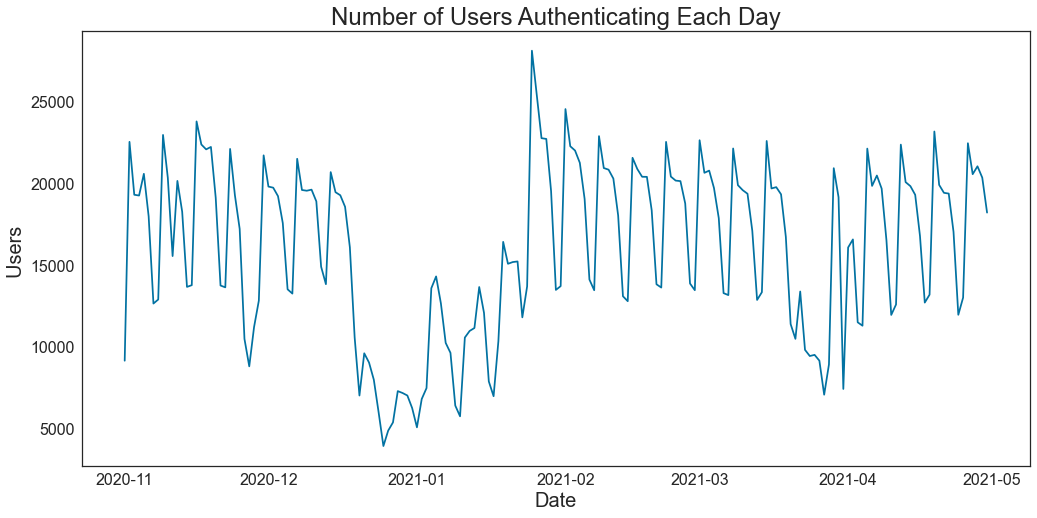

In [117]:
usersPerDay.plot()
sns.set_style("white")
plt.rcParams["figure.figsize"] = (18,8)
plt.ylabel('Users ', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.title('Number of Users Authenticating Each Day', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [15]:
logs.head()

,Timestamp (UTC),Alias,Integration,Factor,Result,Reason,Enrollment,Access Device Country,Access Device State,Access Device City,Access Device Hostname,date,month,hour,minute,second
0,2021-04-01 07:00:07.957411+00:00,user_008576,Single Sign-On,Phone Call,SUCCESS,User approved,False,US,California,Rocklin,NaN,2021-04-01,4,7,0,7
1,2021-04-01 07:00:10.492910+00:00,user_049277,Single Sign-On,Duo Push,SUCCESS,User approved,False,US,California,Santa Maria,NaN,2021-04-01,4,7,0,10
3,2021-04-01 07:00:25.203564+00:00,user_025756,Single Sign-On,Duo Push,SUCCESS,User approved,False,US,California,Lodi,NaN,2021-04-01,4,7,0,25
4,2021-04-01 07:00:27.389194+00:00,user_030286,Single Sign-On,Duo Push,SUCCESS,User approved,False,US,California,Antioch,NaN,2021-04-01,4,7,0,27
5,2021-04-01 07:00:30.814923+00:00,user_019093,Single Sign-On,Duo Push,SUCCESS,User approved,False,PH,Metro Manila,Pasig,NaN,2021-04-01,4,7,0,30


In [59]:
logsPerMonth = logs[logs['Result']=="SUCCESS"].groupby(['month','Alias']).size()

In [60]:
usersPerMonth = logsPerMonth.reset_index()[['month','Alias']].groupby('month').size()

In [61]:
usersPerMonth = usersPerMonth.reindex([11,12,1,2,3,4])

In [62]:
usersPerMonth = usersPerMonth.rename( index={11: '2020-11', 12: '2020-12', 1: '2021-01', 2: '2021-02', 3: '2021-03', 4: '2021-04'})

In [63]:
usersPerMonth.mean()

33633.166666666664

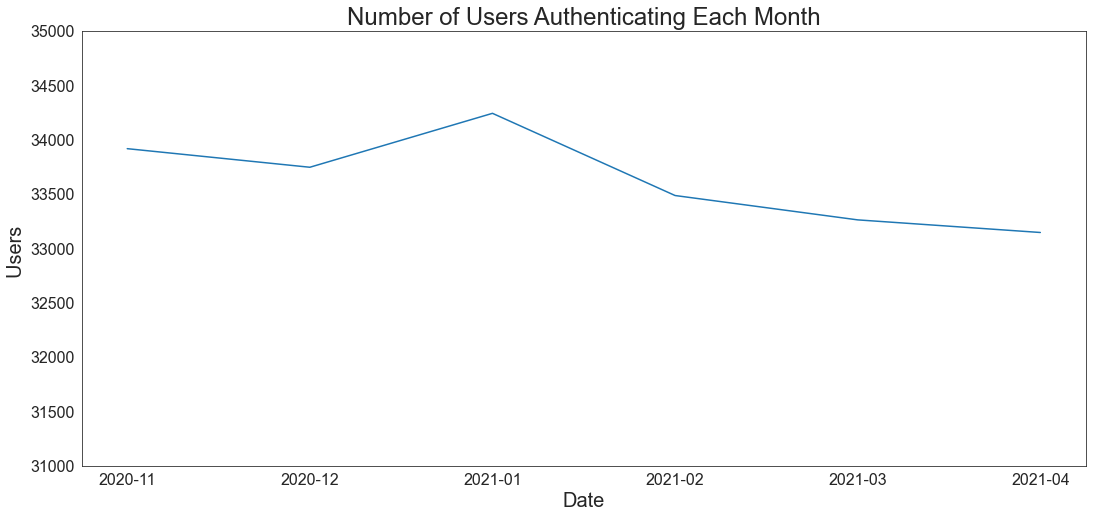

In [64]:
usersPerMonth.plot()
sns.set_style("white")
plt.rcParams["figure.figsize"] = (18,8)
plt.ylabel('Users ', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.title('Number of Users Authenticating Each Month', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(31000,35000)
plt.show()

In [121]:
usersLogsPerDay = logs[logs['Result']=="SUCCESS"].groupby(['date','Alias']).size()